In [1]:
######################################
# Refine moisture budget analysis in -4K, CTL, and +4K
# 1. Make sure KW composite moisture term is normalized by KW precip std
#    -->Verify that qlf, dqlf/dt, wdq/dp@lf are still weaker in +4K after nomalization
#       Verify that wdqdp is the dmoinant term to explain the differences in qlf tendency in difference climates
# 2. Reorganize dignostic related to CLUBB shallow convection (CLUBB-induced temp and q tendency)
# 3. If the timing of CLUBB convection is later than wdq/dp, think about how vertical velocity induced by BL-wind convergence plays a role
#    -->Based on 2 and 3, conclude whether shallow convection or wind convergence dominates the vertical advection of moisture
# 4. Check moisture balance in the mean state, and find the dominant terms that maintain the balance. 
#    Think about how KWs perturb the balance and produce moisture tendency.
# 5. Lack some connection between lower tropospheric temp and shallow convection. Maybe calculate buoyancy.
#######################################################
#  2024.7.18 first written, updated 2024.9.20
# Mu-Ting Chien
##########################################

In [2]:
import os
import sys
sys.path.append('/glade/work/muting/function/')
import KW_diagnostics as KW
import mjo_mean_state_diagnostics as MJO
import create_my_colormap as mycolor
RWB = mycolor.red_white_blue()
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap # for plotting KW composite vertical structure

/glade/u/ssg/ch/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
dir_out            = '/glade/work/muting/KW/'
CASENAME_LIST2     = list(['SST_AQP3_Qobs_27_-4K',\
                          'SST_AQP3_Qobs_27',\
                          'SST_AQP3_Qobs_27_4K'])
CASENAME_SHORT_LIST = list(['-4K','CTL','4K'])
#output_dir_all = dir_out+'output_data/All_3hr_10yr/' # Previous directory
#output_dir_all_3yr = dir_out+'output_data/All_3hr_3yr/' # Previous directory
output_dir_all          = dir_out+'output_data/Paper4_20240822/' # updated directory
#figdir_all     = dir_out+'figure/Post_general/Paper4/' # Previous directory
figdir = dir_out+'figure/Post_general/Paper4_20240822/' #updated directory
figdir_supplement = figdir+'Supplement/'
os.makedirs(figdir,exist_ok=True) 
os.makedirs(output_dir_all,exist_ok=True) 
legend_list = list(['-4K','CTL','+4K']) # Change this if using nudging data

s2d = 86400
Cp = 1004.64
iyr_min = 2
iyr_max = 4
nyr = iyr_max-iyr_min+1
yr = np.arange(0,nyr)+1
latmax = 10

# Parameters for KW composite
PI = '\u03C0'
pi = np.pi
bin_simple = np.arange(-pi,pi+1/4*pi,1/4*pi)
bin_simple2 = np.arange(-pi,pi+1/2*pi,1/2*pi)
title = list(['(a) -4K','(b) CTL','(c) +4K'])

In [5]:
# Load EOF
data = np.load(output_dir_all+'EOF_all.npz')
EOFQ1 = data['EOFQ1'][2:-2,:]
EOFQ2 = data['EOFQ2'][2:-2,:]
plev  = data['plev'][2:-2]
nlev = np.size(plev)

In [6]:
# Load KW composite variables
save_kw_composite = 0 # already saved = 1, not yet saved = 0
normalize_by_kwamp_pr_T = 1 #0:no nomalization, 1:by PR, 2:by T

if save_kw_composite == 0:
    for icase in range(0,3):
        if icase != 1:
            CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new'
        else:
            CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new_uv_tendency'
        CASENAME_SHORT = CASENAME_SHORT_LIST[icase]+'_CLUBB_new'
        output_dir     = dir_out+'output_data/'+CASENAME+'/'
    
        # 0-1. Load KW amplitude (BY PRECIP)
        data  = np.load(output_dir+'precip_kw.npz') #other variables: time_pr, phase_correct
        phase = data['phase_bin']
        nphase = np.size(phase)
        if icase == 0:
            kwamp_all = np.empty([3])
            pr_KW_all = np.empty([nphase, 3])
        kwamp_pr = ( np.max(data['pr_kw'])-np.min(data['pr_kw']) )/2
        pr_KW_all[:,icase] = data['pr_kw']
        #print(kwamp)
        
        # 0.2. Load T KW (CALCULATE KW AMPLITUDE BY T2)
        data = np.load(output_dir+'T_kwcomposite.npz')
        if icase == 0:
            T_KW_all = np.empty([nphase, nlev, 3])
        T_KW_all[:,:,icase] = data['T_KW'][:,2:-2]#/kwamp
        kwamp_T = ( np.max( np.inner(T_KW_all[:,:,icase], EOFQ2[:,icase]) ) - np.min( np.inner(T_KW_all[:,:,icase], EOFQ2[:,icase]) ) )/2
        #print(kwamp_T)
    
        if normalize_by_kwamp_pr_T == 1:
            kwamp = kwamp_pr
        elif normalize_by_kwamp_pr_T == 2:
            kwamp = kwamp_T
        else:
            kwamp = 1
        kwamp_all[icase] = kwamp
    
        T_KW_all[:,:,icase] = T_KW_all[:,:,icase]#/kwamp
        
        # 1. Load KW composite q
        data      = np.load(output_dir+'q_kwcomposite.npz')
        phase     = data['phase']
        plev      = data['plev'][2:-2] # So that it has the same dimension with budget term below (75-950 hPa)
        nlev      = np.size(plev)
        nphase    = np.size(phase)
        if icase == 0:
            q_KW_all = np.empty([nphase, nlev, 3])
            q1000_KW_all = np.empty([nphase, 3])
        q_KW_all[:,:,icase] = data['q_KW'][:,2:-2]*1000#/kwamp 
        q1000_KW_all[:,icase] = data['q_KW'][:,-1]*1000#/kwamp
        
        # 2. Load KW composite moisture budget term
        data      = np.load(output_dir+'dqdt_udqdx_vdqdy_wdqdp_Q2_kwcomposite.npz')
        if icase == 0:
            #plev       = data['plev'][1:] # So that it has the same dimension with RH
            wdqdp_KW_all   = np.empty([nphase, nlev, 3])
            Q2moist_KW_all = np.empty([nphase, nlev, 3])
            dqdt_KW_all    = np.empty([nphase, nlev, 3])
            udqdx_KW_all   = np.empty([nphase, nlev, 3])
            vdqdy_KW_all   = np.empty([nphase, nlev, 3])
        Q2moist_KW_all[:,:,icase] = -data['Q2_KW'][:,1:]#/kwamp
        wdqdp_KW_all[:,:,icase]   = -data['wdqdp_KW'][:,1:]#/kwamp
        udqdx_KW_all[:,:,icase]   = -data['udqdx_KW'][:,1:]#/kwamp
        vdqdy_KW_all[:,:,icase]   = -data['vdqdy_KW'][:,1:]
        dqdt_KW_all[:,:,icase]    = data['dqdt_KW'][:,1:]#/kwamp
    
        # 3. Load KW composite du/dx and dv/dy
        data      = np.load(output_dir+'dudx_dvdy_kwcomposite.npz')
        if icase == 0:
            dudx_KW_all = np.empty([nphase, nlev, 3])
            dvdy_KW_all = np.empty([nphase, nlev, 3])
        dudx_KW_all[:,:,icase] = data['dudx_KW'][:,2:-1]#/kwamp # make sure it starts from 75 to 950 hPa
        dvdy_KW_all[:,:,icase] = data['dvdy_KW'][:,2:-1]#/kwamp
    
        # 4. Load Q clubb
        data      = np.load(output_dir+'dTdt_each_term_kwcomposite.npz')
        if icase == 0:
            Q_CLUBB_KW_all = np.empty([nphase, nlev, 3])
            Q_KW_all       = np.empty([nphase, nlev, 3]) #DTCOND
        Q_CLUBB_KW_all[:,:,icase] = data['STEND_CLUBB_KW'][:,2:-2]*s2d#/kwamp
        Q_KW_all[:,:,icase] = data['DTCOND_KW'][:,2:-2]*s2d#/kwamp
        
        # 5. Load omega and gph
        data = np.load(output_dir+'uvwz_kwcomposite.npz')
        if icase == 0:
            u_KW_all   = np.empty([nphase, nlev, 3])
            v_KW_all   = np.empty([nphase, nlev, 3])
            w_KW_all   = np.empty([nphase, nlev, 3])
            gph_KW_all = np.empty([nphase, nlev, 3])
            u1000_KW_all = np.empty([nphase, 3])
    
        u1000_KW_all[:,icase] = data['u_KW'][:,-1]#/kwamp
        u_KW_all[:,:,icase]   = data['u_KW'][:,2:-2]#/kwamp
        v_KW_all[:,:,icase]   = data['v_KW'][:,2:-2]#/kwamp
        w_KW_all[:,:,icase]   = data['w_KW'][:,2:-2]#/kwamp
        gph_KW_all[:,:,icase] = data['gph_KW'][:,2:-2]#/kwamp
    
        # 6. Load LH KW
        data = np.load(output_dir+'LH_kwcomposite.npz')
        if icase == 0:
            LH_KW_all = np.empty([nphase, 3])
        LH_KW_all[:,icase] = data['LH_KW']#/kwamp        
        
        # 7. Load ZMMU (updraft mass flux from ZM scheme)
        CASENAME2       = CASENAME_LIST2[icase]+'_DTCOND'
        output_dir2 = dir_out+'output_data/'+CASENAME2+'/'
        data  = np.load(output_dir2+'ZM_MP_kw.npz')
        if icase == 0:
            ZMMU_KW_all = np.empty([nphase, nlev, 3])
        ZMMU_KW_all[:,:,icase] = data['ZMMU_KW'][:,2:-2]#/kwamp # kg/m2/s
    
        ########################
        # load mean state T, Calculate RH KW
    
        for icase in range(0,3):
        
            if icase != 1:
                CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new'
            else:
                CASENAME       = CASENAME_LIST2[icase]+'_3h_20y_CLUBB_new_uv_tendency'
            output_dir = dir_out+'output_data/'+CASENAME+'/'
            data = np.load(output_dir+'QTUVZq.npz')
            plev_m = data['plev']
            nlev_m = np.size(plev_m)
            if icase == 0:
                Tm = np.empty([nlev, 3])
                qm = np.empty([nlev, 3])
                um = np.empty([nlev, 3])
            Tm[:,icase] = data['Tm'][2:-2]
            qm[:,icase] = data['qm'][2:-2]
            um[:,icase] = data['Um'][2:-2]
    
    Tm_KW = np.tile(Tm, (np.size(phase),1,1))
    qm_KW = np.tile(qm, (np.size(phase),1,1))
    um_KW = np.tile(um, (np.size(phase),1,1))
    
    T_KW_total = T_KW_all+Tm_KW
    q_KW_total = q_KW_all*0.001+qm_KW
    u_KW_total = u_KW_all+um_KW
    uspeed_KW_total = np.abs(u_KW_total)
    uspeed_KW_mean = np.mean(uspeed_KW_total, 0)
    uspeed_KW_all = uspeed_KW_total-uspeed_KW_mean
    
    e, qs_KW_total = KW.cc_equation(T_KW_total, plev)
    rh_KW_total = q_KW_total/qs_KW_total
    rh_KW_mean = np.mean(rh_KW_total, 0)
    rh_KW_mean = np.tile(rh_KW_mean, (nphase, 1, 1))
    rh_KW_all = rh_KW_total - rh_KW_mean
    
    qs_KW_mean = np.mean(qs_KW_total, 0)
    qs_KW_mean = np.tile(qs_KW_mean, (nphase, 1, 1))
    qs_KW_all = qs_KW_total - qs_KW_mean
    
    # Unit: q in g/kg, Q in K/day
    np.savez(output_dir_all+'KW_composite_3D_all.npz', T_KW_all=T_KW_all, q_KW_all=q_KW_all,\
             Q2moist_KW_all=Q2moist_KW_all, dqdt_KW_all=dqdt_KW_all, wdqdp_KW_all=wdqdp_KW_all, udqdx_KW_all=udqdx_KW_all, vdqdy_KW_all=vdqdy_KW_all,\
             dudx_KW_all=dudx_KW_all, dvdy_KW_all=dvdy_KW_all,\
             u_KW_all=u_KW_all, v_KW_all=v_KW_all, w_KW_all=w_KW_all, gph_KW_all=gph_KW_all,\
             uspeed_KW_total=uspeed_KW_total, uspeed_KW_all=uspeed_KW_all,
             Q_KW_all=Q_KW_all, Q_CLUBB_KW_all=Q_CLUBB_KW_all, ZMMU_KW_all=ZMMU_KW_all,\
            rh_KW_total=rh_KW_total, rh_KW_all=rh_KW_all, qs_KW_total=qs_KW_total, qs_KW_all=qs_KW_all, \
             plev=plev, phase=phase)
    
    np.savez(output_dir_all+'KW_composite_2D_all.npz', pr_KW_all=pr_KW_all, LH_KW_all=LH_KW_all,\
             u1000_KW_all=u1000_KW_all, q1000_KW_all=q1000_KW_all, phase=phase)
    
    np.savez(output_dir_all+'KW_amplitude_pr_all.npz', kwamp_all=kwamp_all)

    # Normalize by KW amp: 3D
    T_KW_all       = T_KW_all/kwamp_all
    q_KW_all       = q_KW_all/kwamp_all
    Q_KW_all       = Q_KW_all/kwamp_all
    Q_CLUBB_KW_all = Q_CLUBB_KW_all/kwamp_all
    Q2moist_KW_all = Q2moist_KW_all/kwamp_all
    dqdt_KW_all    = dqdt_KW_all/kwamp_all
    wdqdp_KW_all   = wdqdp_KW_all/kwamp_all
    udqdx_KW_all   = udqdx_KW_all/kwamp_all
    u_KW_all       = u_KW_all/kwamp_all
    v_KW_all       = v_KW_all/kwamp_all
    w_KW_all       = w_KW_all/kwamp_all
    gph_KW_all     = gph_KW_all/kwamp_all
    uspeed_KW_all  = uspeed_KW_all/kwamp_all
    ZMMU_KW_all    = ZMMU_KW_all/kwamp_all
    rh_KW_all      = rh_KW_all/kwamp_all
    qs_KW_all      = qs_KW_all/kwamp_all

    # Normalize by KW amp: 2D
    LH_KW_all    = LH_KW_all/kwamp_all
    u1000_KW_all = u1000_KW_all/kwamp_all
    q1000_KW_all = q1000_KW_all/kwamp_all

else:
    # Load KW amplitude
    data       = np.load(output_dir_all+'KW_amplitude_pr_all.npz')
    kwamp_all = data['kwamp_all']
    
    # Load KW composite 3D variables and normalize
    data           = np.load(output_dir_all+'KW_composite_3D_all.npz')
    T_KW_all       = data['T_KW_all']/kwamp_all
    q_KW_all       = data['q_KW_all']/kwamp_all
    Q2moist_KW_all = data['Q2moist_KW_all']/kwamp_all
    dqdt_KW_all    = data['dqdt_KW_all']/kwamp_all
    wdqdp_KW_all   = data['wdqdp_KW_all']/kwamp_all
    udqdx_KW_all   = data['udqdx_KW_all']/kwamp_all
    u_KW_all       = data['u_KW_all']/kwamp_all
    v_KW_all       = data['v_KW_all']/kwamp_all
    w_KW_all       = data['w_KW_all']/kwamp_all
    gph_KW_all     = data['gph_KW_all']/kwamp_all
    uspeed_KW_all  = data['uspeed_KW_all']/kwamp_all
    Q_KW_all       = data['Q_KW_all']/kwamp_all
    Q_CLUBB_kw_all = data['Q_CLUBB_KW_all']/kwamp_all
    ZMMU_KW_all    = data['ZMMU_KW_all']/kwamp_all
    rh_KW_all      = data['rh_KW_all']/kwamp_all
    qs_KW_all      = data['qs_KW_all']/kwamp_all
        
    # Load KW composite 2D variables and normalize
    data           = np.load(output_dir_all+'KW_composite_2D_all.npz')
    LH_KW_all      = data['LH_KW_all']/kwamp_all
    u1000_KW_all   = data['u1000_KW_all']/kwamp_all
    q1000_KW_all   = data['q1000_KW_all']/kwamp_all

'''
np.savez(output_dir_all+'RH_qs_kwcomposite_all.npz', rh_KW_total=rh_KW_total, rh_KW_all=rh_KW_all,\
         qs_KW_total=qs_KW_total, qs_KW_all=qs_KW_all,\
             plev=plev, phase=phase)

np.savez(output_dir_all+'uspeed_kwcomposite_all.npz', uspeed_KW_total=uspeed_KW_total, uspeed_KW_all=uspeed_KW_all,\
             plev=plev, phase=phase)
'''

"\nnp.savez(output_dir_all+'RH_qs_kwcomposite_all.npz', rh_KW_total=rh_KW_total, rh_KW_all=rh_KW_all,         qs_KW_total=qs_KW_total, qs_KW_all=qs_KW_all,             plev=plev, phase=phase)\n\nnp.savez(output_dir_all+'uspeed_kwcomposite_all.npz', uspeed_KW_total=uspeed_KW_total, uspeed_KW_all=uspeed_KW_all,             plev=plev, phase=phase)\n"

In [30]:
# Load KW frequency from 10-year data (caution!), start here
data = np.load(output_dir_all+'KW_amplitude_gr_Cp_all_10yr.npz')
freq_ave = data['freq_ave']
zwnum_ave = data['zwnum_ave']

In [21]:
# Calculate vertical mode decomposition
for icase in range(0,3):
    tmp1, tmp2 = KW.vertical_mode_decomposition(T_KW_all[:,:,icase], EOFQ1[:,icase], EOFQ2[:,icase])
    if icase == 0:
        T1_KW_all = np.empty([nphase, nlev, 3])
        T2_KW_all = np.empty([nphase, nlev, 3])
    T1_KW_all[:,:,icase] = tmp1
    T2_KW_all[:,:,icase] = tmp2

In [39]:
#######################################
# Find the average value over lf and bl
#######################################
# Find plev index for lower free troposphere and boundary layer

# Lower free troposphere
ilev_min_lf = np.argwhere(plev==750).squeeze()
ilev_max_lf = np.argwhere(plev==850).squeeze()

# Boundary layer
ilev_min_bl = np.argwhere(plev==850).squeeze()
ilev_max_bl = np.argwhere(plev==950).squeeze()

###########################
# This is used for KW composite line plot
nph = np.size(phase)
zero = np.zeros([nph])
##################################

qlf_KW_all = np.mean(q_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
qbl_KW_all = np.mean(q_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)

dqdt_lf_KW_all = np.mean(dqdt_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
dqdt_bl_KW_all = np.mean(dqdt_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)

wdqdp_lf_KW_all = np.mean(wdqdp_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
wdqdp_bl_KW_all = np.mean(wdqdp_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)

Q2_lf_KW_all = np.mean(Q2moist_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
Q2_bl_KW_all = np.mean(Q2moist_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)

udqdx_lf_KW_all = np.mean(udqdx_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
udqdx_bl_KW_all = np.mean(udqdx_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)

wdqdp_Q2_udqdx_lf_KW_all = wdqdp_lf_KW_all+Q2_lf_KW_all+udqdx_lf_KW_all
wdqdp_Q2_udqdx_bl_KW_all = wdqdp_bl_KW_all+Q2_bl_KW_all+udqdx_bl_KW_all

wdqdp_Q2_lf_KW_all = wdqdp_lf_KW_all+Q2_lf_KW_all
wdqdp_Q2_bl_KW_all = wdqdp_bl_KW_all+Q2_bl_KW_all

Q_CLUBB_lf_KW_all = np.mean(Q_CLUBB_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
w_lf_KW_all       = np.mean(w_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
u_bl_KW_all       = np.mean(u_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)

dudx_lf_KW_all    = np.mean(dudx_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
dudx_bl_KW_all    = np.mean(dudx_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)

gph_lf_KW_all     = np.mean(gph_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
gph_bl_KW_all     = np.mean(gph_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)

T_lf_KW_all  = np.mean(T_KW_all[:,  ilev_min_lf:ilev_max_lf+1, :], 1)
T1_lf_KW_all = np.mean(T1_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
T2_lf_KW_all = np.mean(T2_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)
#
T_bl_KW_all  = np.mean(T_KW_all[:,  ilev_min_bl:ilev_max_bl+1, :], 1)
T1_bl_KW_all = np.mean(T1_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)
T2_bl_KW_all = np.mean(T2_KW_all[:, ilev_min_bl:ilev_max_bl+1, :], 1)

rh_lf_KW_all = np.mean(rh_KW_all[:,  ilev_min_lf:ilev_max_lf+1, :], 1)
rh_bl_KW_all = np.mean(rh_KW_all[:,  ilev_min_bl:ilev_max_bl+1, :], 1)

uspeed_1000_KW_all = uspeed_KW_all[:,-1,:]

ZMMU_lf_KW_all = np.mean(ZMMU_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)

Q_lf_KW_all  = np.mean(Q_KW_all[:, ilev_min_lf:ilev_max_lf+1, :], 1)

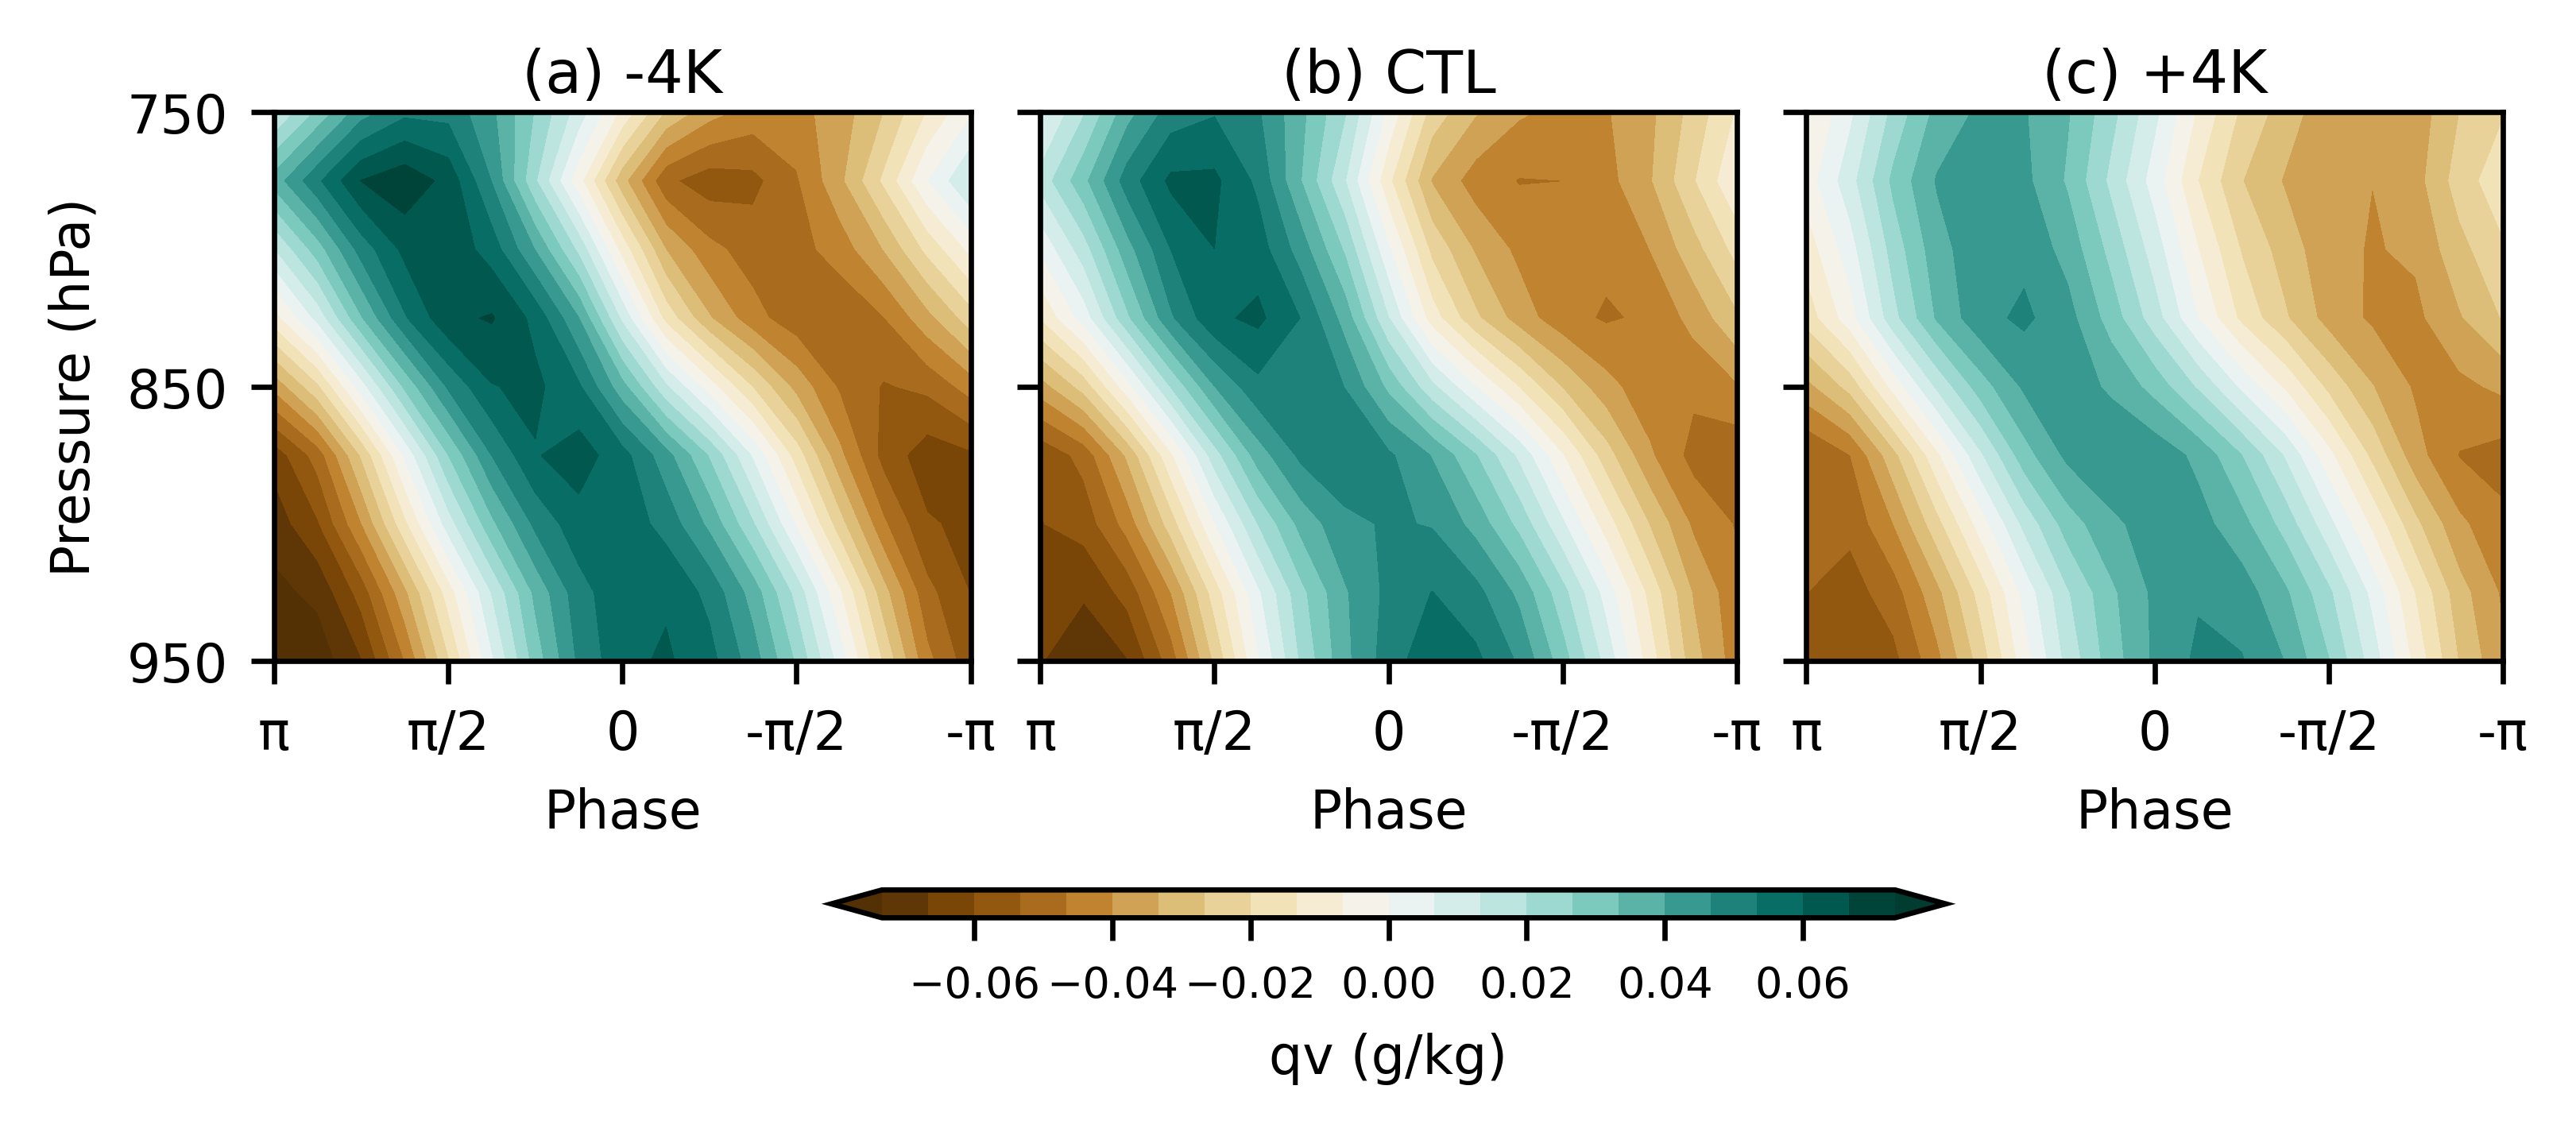

In [24]:
#####################################
# Plot KW compostie q vertical structure 
##########################################
title = list(['(a) -4K', '(b) CTL','(c) +4K'])
font = 8
plev_min = 750
for iplt in range(1,2): # only plot qv, not RH
    fig,axes = plt.subplots(1,3,figsize=(5.5, 2.4),dpi=600)
    plt.subplots_adjust(left=0.1,right=0.95,top=0.9,bottom=0.1,wspace=0.1)
    plt.rcParams.update({'font.size': font})

    for icase in range(0,3):
        plt.subplot(1, 3,icase+1)
        ax = plt.gca()
        plt.title(title[icase], pad=3, loc='center',fontsize=9)
        xx, yy = np.meshgrid(phase,plev)
        if normalize_by_kwamp_pr_T == 1:
            clev = np.arange(-0.22,0.24,0.02)/3
            ticks = np.arange(-0.06,0.09,0.03)
        elif normalize_by_kwamp_pr_T == 2:
            clev = np.arange(-0.24,0.26,0.02)
            #ticks = np.arange(-0.24,0.24,0.06)
        cf  = plt.contourf(xx, yy, q_KW_all[:,:,icase].T, levels=clev, cmap='BrBG', extend='both' )
        #cn_p_Q = plt.contour(xx, yy, Q_res_kw[:,:,icase].T, levels=clev_p_Q, colors='k', linewidths=0.8)
        #cn_n_Q = plt.contour(xx, yy, Q_res_kw[:,:,icase].T, levels=clev_n_Q, colors='k', linestyles='dashed',linewidths=0.8) 
        if plev_min == 700:
            plt.yticks(np.arange(700,1000,50))
        elif plev_min == 750:
            plt.yticks(np.arange(750,1050,100))
        #plt.ylim([700,950])
        plt.ylim([plev_min,950])
        
        plt.xlabel('Phase')
        plt.gca().invert_yaxis()
        plt.xticks(bin_simple2,(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=8)
        plt.tick_params(bottom=True,top=False,left=True,right=False)
        if icase == 0:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
            ax.set_ylabel('Pressure (hPa)',fontsize=font)
        elif icase == 1:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)
        elif icase == 2:
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=False,labelright=False)

    cb = plt.colorbar(cf, ax = axes, orientation = 'horizontal', shrink=.5, aspect=40,pad=0.25) 
    cb.set_label('qv (g/kg)')
    cb.ax.tick_params(labelsize=6.5)
    #cb.set_ticks(ticks)
    plt.savefig(figdir+'Fig.4_KWcomposite_q_'+str(plev_min)+'.png',dpi=600)  
    plt.show()

In [40]:
######################
# Load data for Fig. 10 (Schematic)
#####################
ilev_lf_q = np.argwhere(plev==750).squeeze()
ilev_lf_gph = np.argwhere(plev==650).squeeze()
q_only_lf_KW_all                     = np.empty([nphase, nlev, 3])
q_only_lf_KW_all[:]                  = np.nan
q_only_lf_KW_all[:,ilev_lf_q:,:]     = q_KW_all[:,ilev_lf_q:,:]
gph_only_lf_KW_all                   = np.empty([nphase, nlev, 3])
gph_only_lf_KW_all[:]                = np.nan
gph_only_lf_KW_all[:,ilev_lf_gph:,:] = gph_KW_all[:,ilev_lf_gph:,:]
u_only_lf_KW_all                     = np.empty([nphase, nlev, 3])
u_only_lf_KW_all[:]                  = np.nan
u_only_lf_KW_all[:,ilev_lf_q:,:]     = u_KW_all[:,ilev_lf_q:,:]
w_only_lf_KW_all                     = np.empty([nphase, nlev, 3])
w_only_lf_KW_all[:]                  = np.nan
w_only_lf_KW_all[:,ilev_lf_q:,:]     = w_KW_all[:,ilev_lf_q:,:]

# Rescale the u by considering the wavelength
KW_zonal_wavelength = 2*np.pi*6371*1000/zwnum_ave # This is the physical distance of the x-axis in meter
u_norm = u_only_lf_KW_all/KW_zonal_wavelength
w_norm = w_only_lf_KW_all/(950-150)/100 # The below schematic starts from 950 to 150 hPa

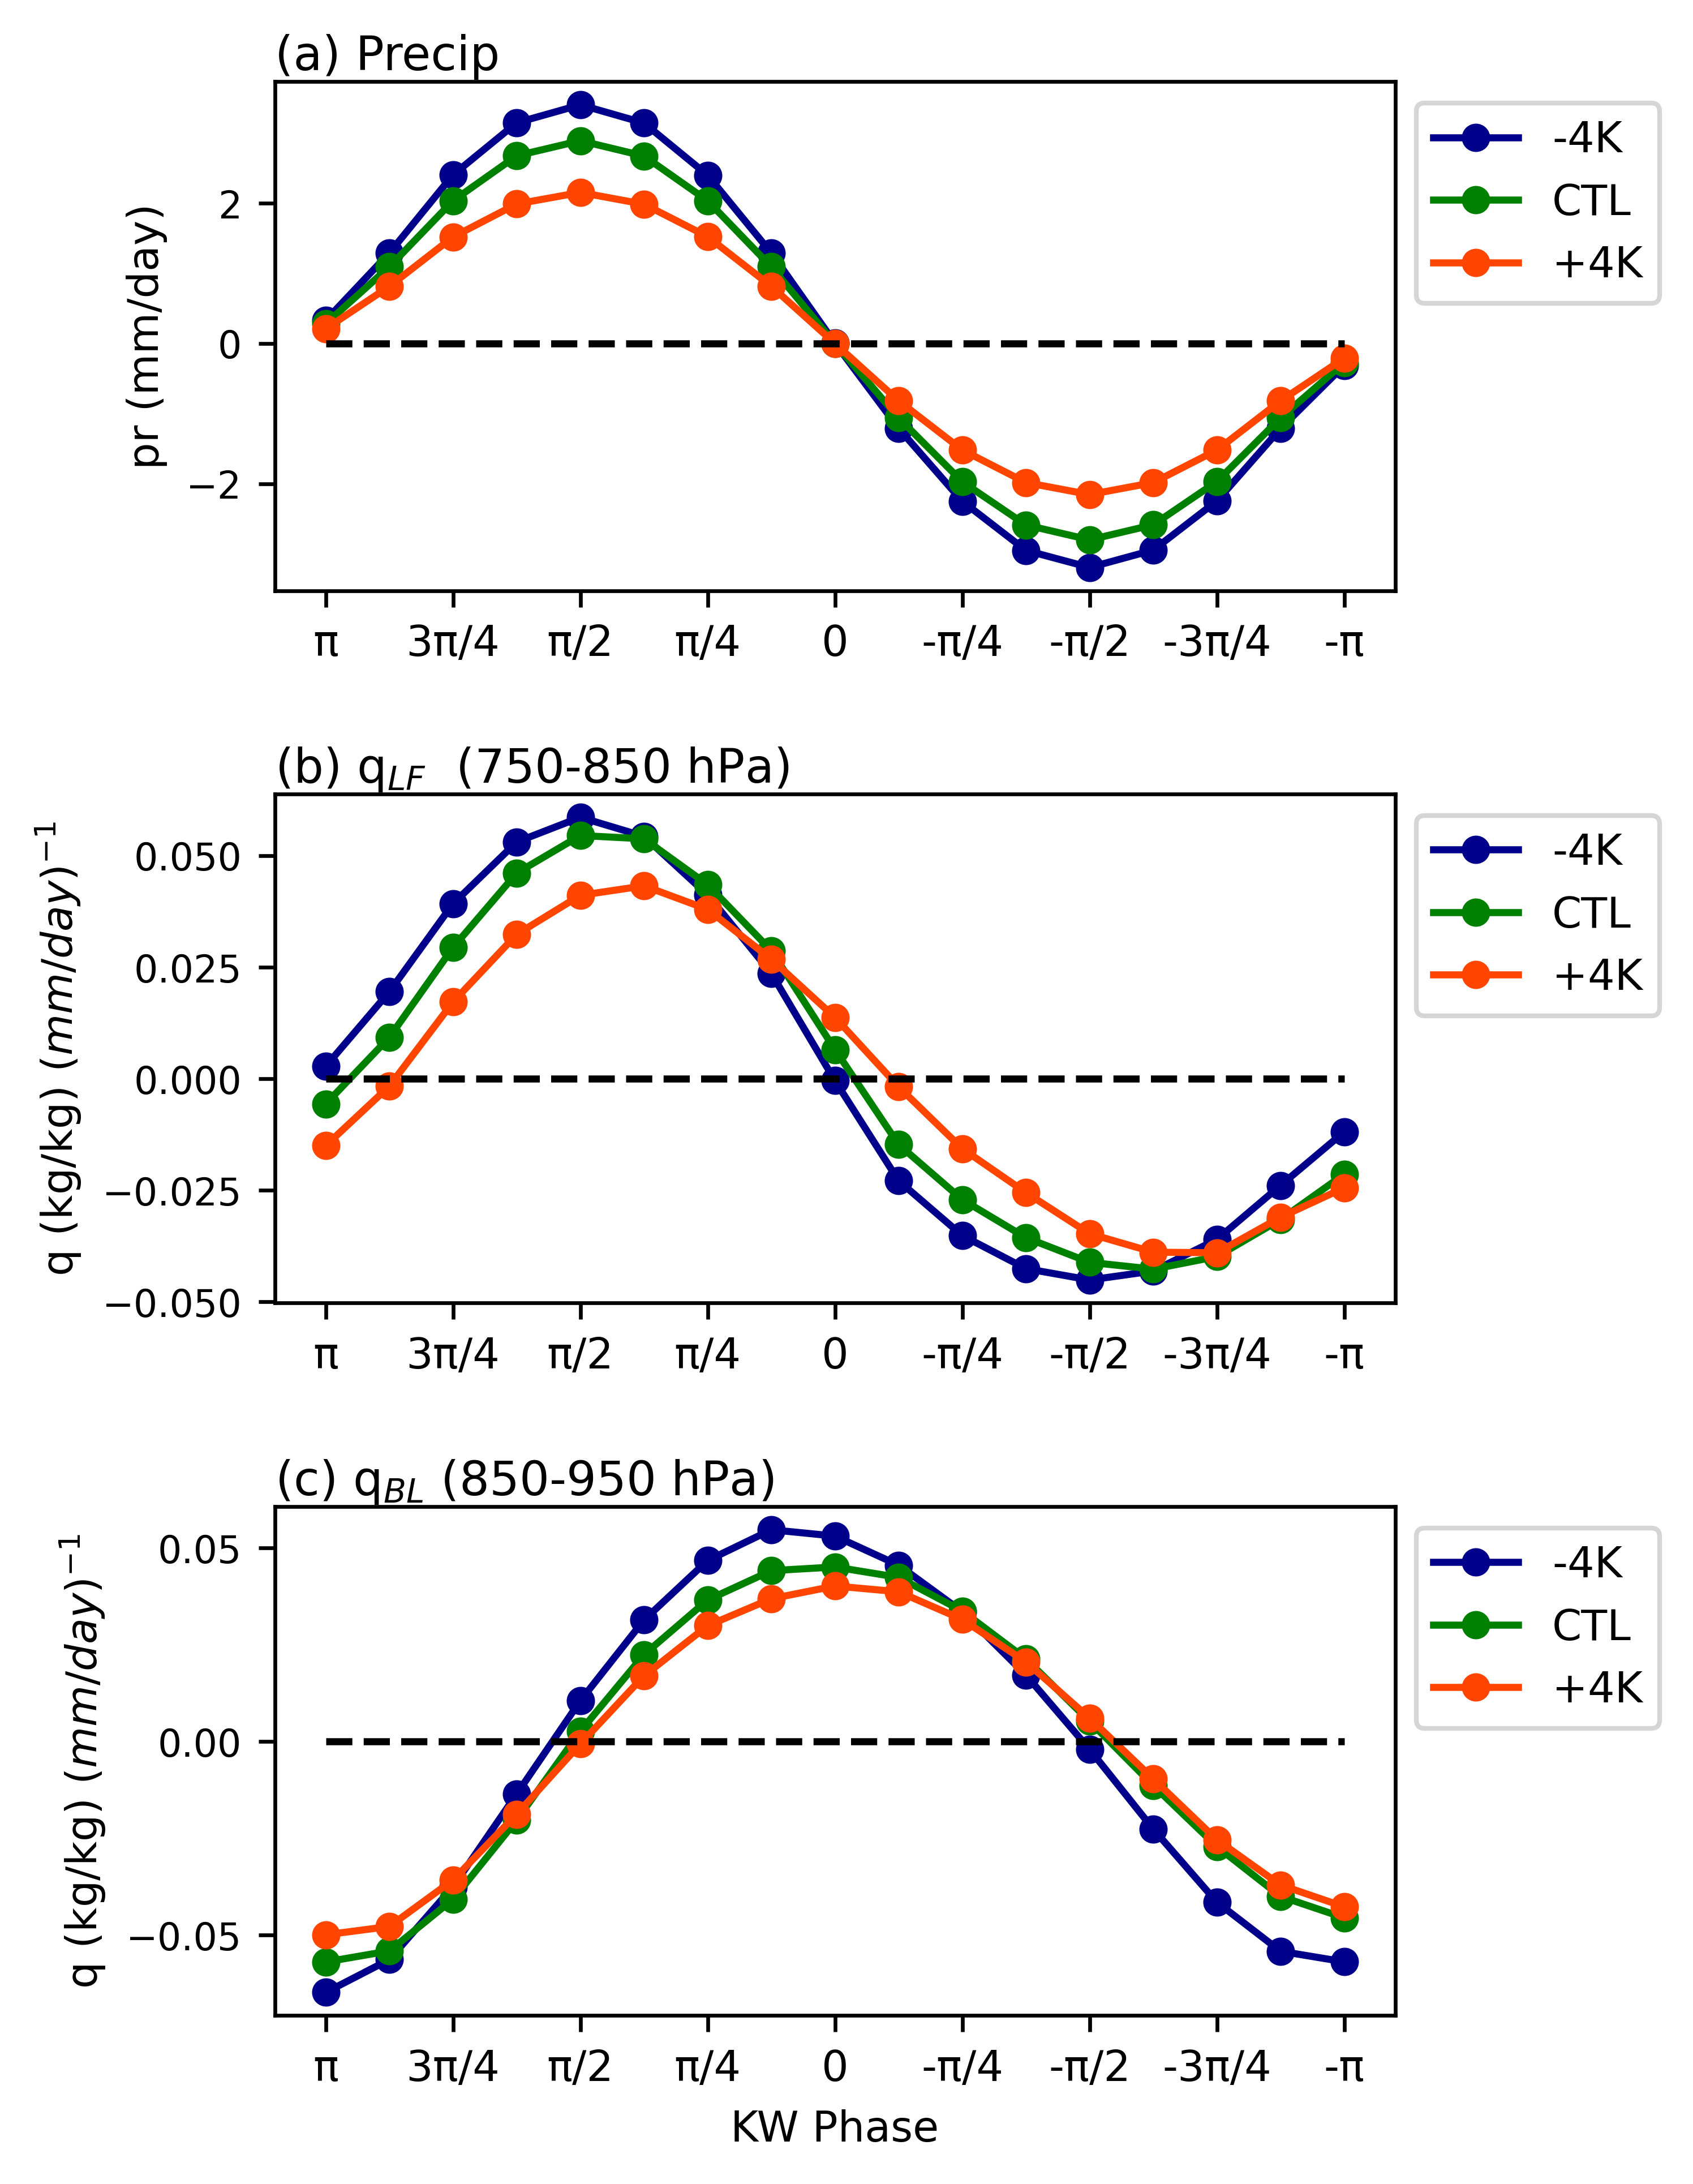

In [25]:
########################################
# Quantify qlf and qbl
##################################
# Plot KW compoiste qlf and qbl
title_list = list(['(a) Precip','(b) q$_{LF}$','(c) q$_{BL}$']) #'(c) DCIN','(d) T$_{2}$','(e) LH'])
vname_list = list(['pr','qlf','qbl'])
subtitle_list = list(['','  (750-850 hPa)',' (850-950 hPa)'])

nph = np.size(phase)
zero = np.zeros([nph])
fig_name = 'Fig.5_KW_pr_qlf_qbl.png'
#fig = plt.subplots(2,1,figsize=(5.5, 4.7),dpi=600)
fig = plt.subplots(3,1,figsize=(5.5, 6.7),dpi=600)
plt.subplots_adjust(left=0.2,right=0.8,top=0.95,bottom=0.1, hspace=0.4)
plt.rcParams.update({'font.size': 9})
for iplt in range(0,3):
    plt.subplot(3,1,iplt+1)
    V = globals()[vname_list[iplt]+'_KW_all']
    plt.title(title_list[iplt]+subtitle_list[iplt], pad=2.5, loc='left',fontsize=10)
    plt.plot(phase, V[:,0],color='darkblue',marker='o',markersize=5)
    plt.plot(phase, V[:,1],color='g',marker='o',markersize=5)
    plt.plot(phase, V[:,2],color='orangered',marker='o',markersize=5)
    plt.plot(phase, zero,'k--')
    ax = plt.gca()
    ax.legend(legend_list, bbox_to_anchor=(1, 1), loc='upper left',fontsize=9)
    plt.xticks(bin_simple,(PI,'3'+PI+'/4',PI+'/2',PI+'/4','0','-'+PI+'/4','-'+PI+'/2','-3'+PI+'/4','-'+PI),\
               fontsize=9)
    if iplt == 0:
        plt.ylabel('pr (mm/day)',fontsize=9)
    else:
        plt.ylabel('q (kg/kg) $({mm/day})^{-1}$',fontsize=9)

    if iplt == 2:
        plt.xlabel('KW Phase',fontsize=9)

plt.savefig(figdir+fig_name,format='png', dpi=600)
plt.show()
plt.close()

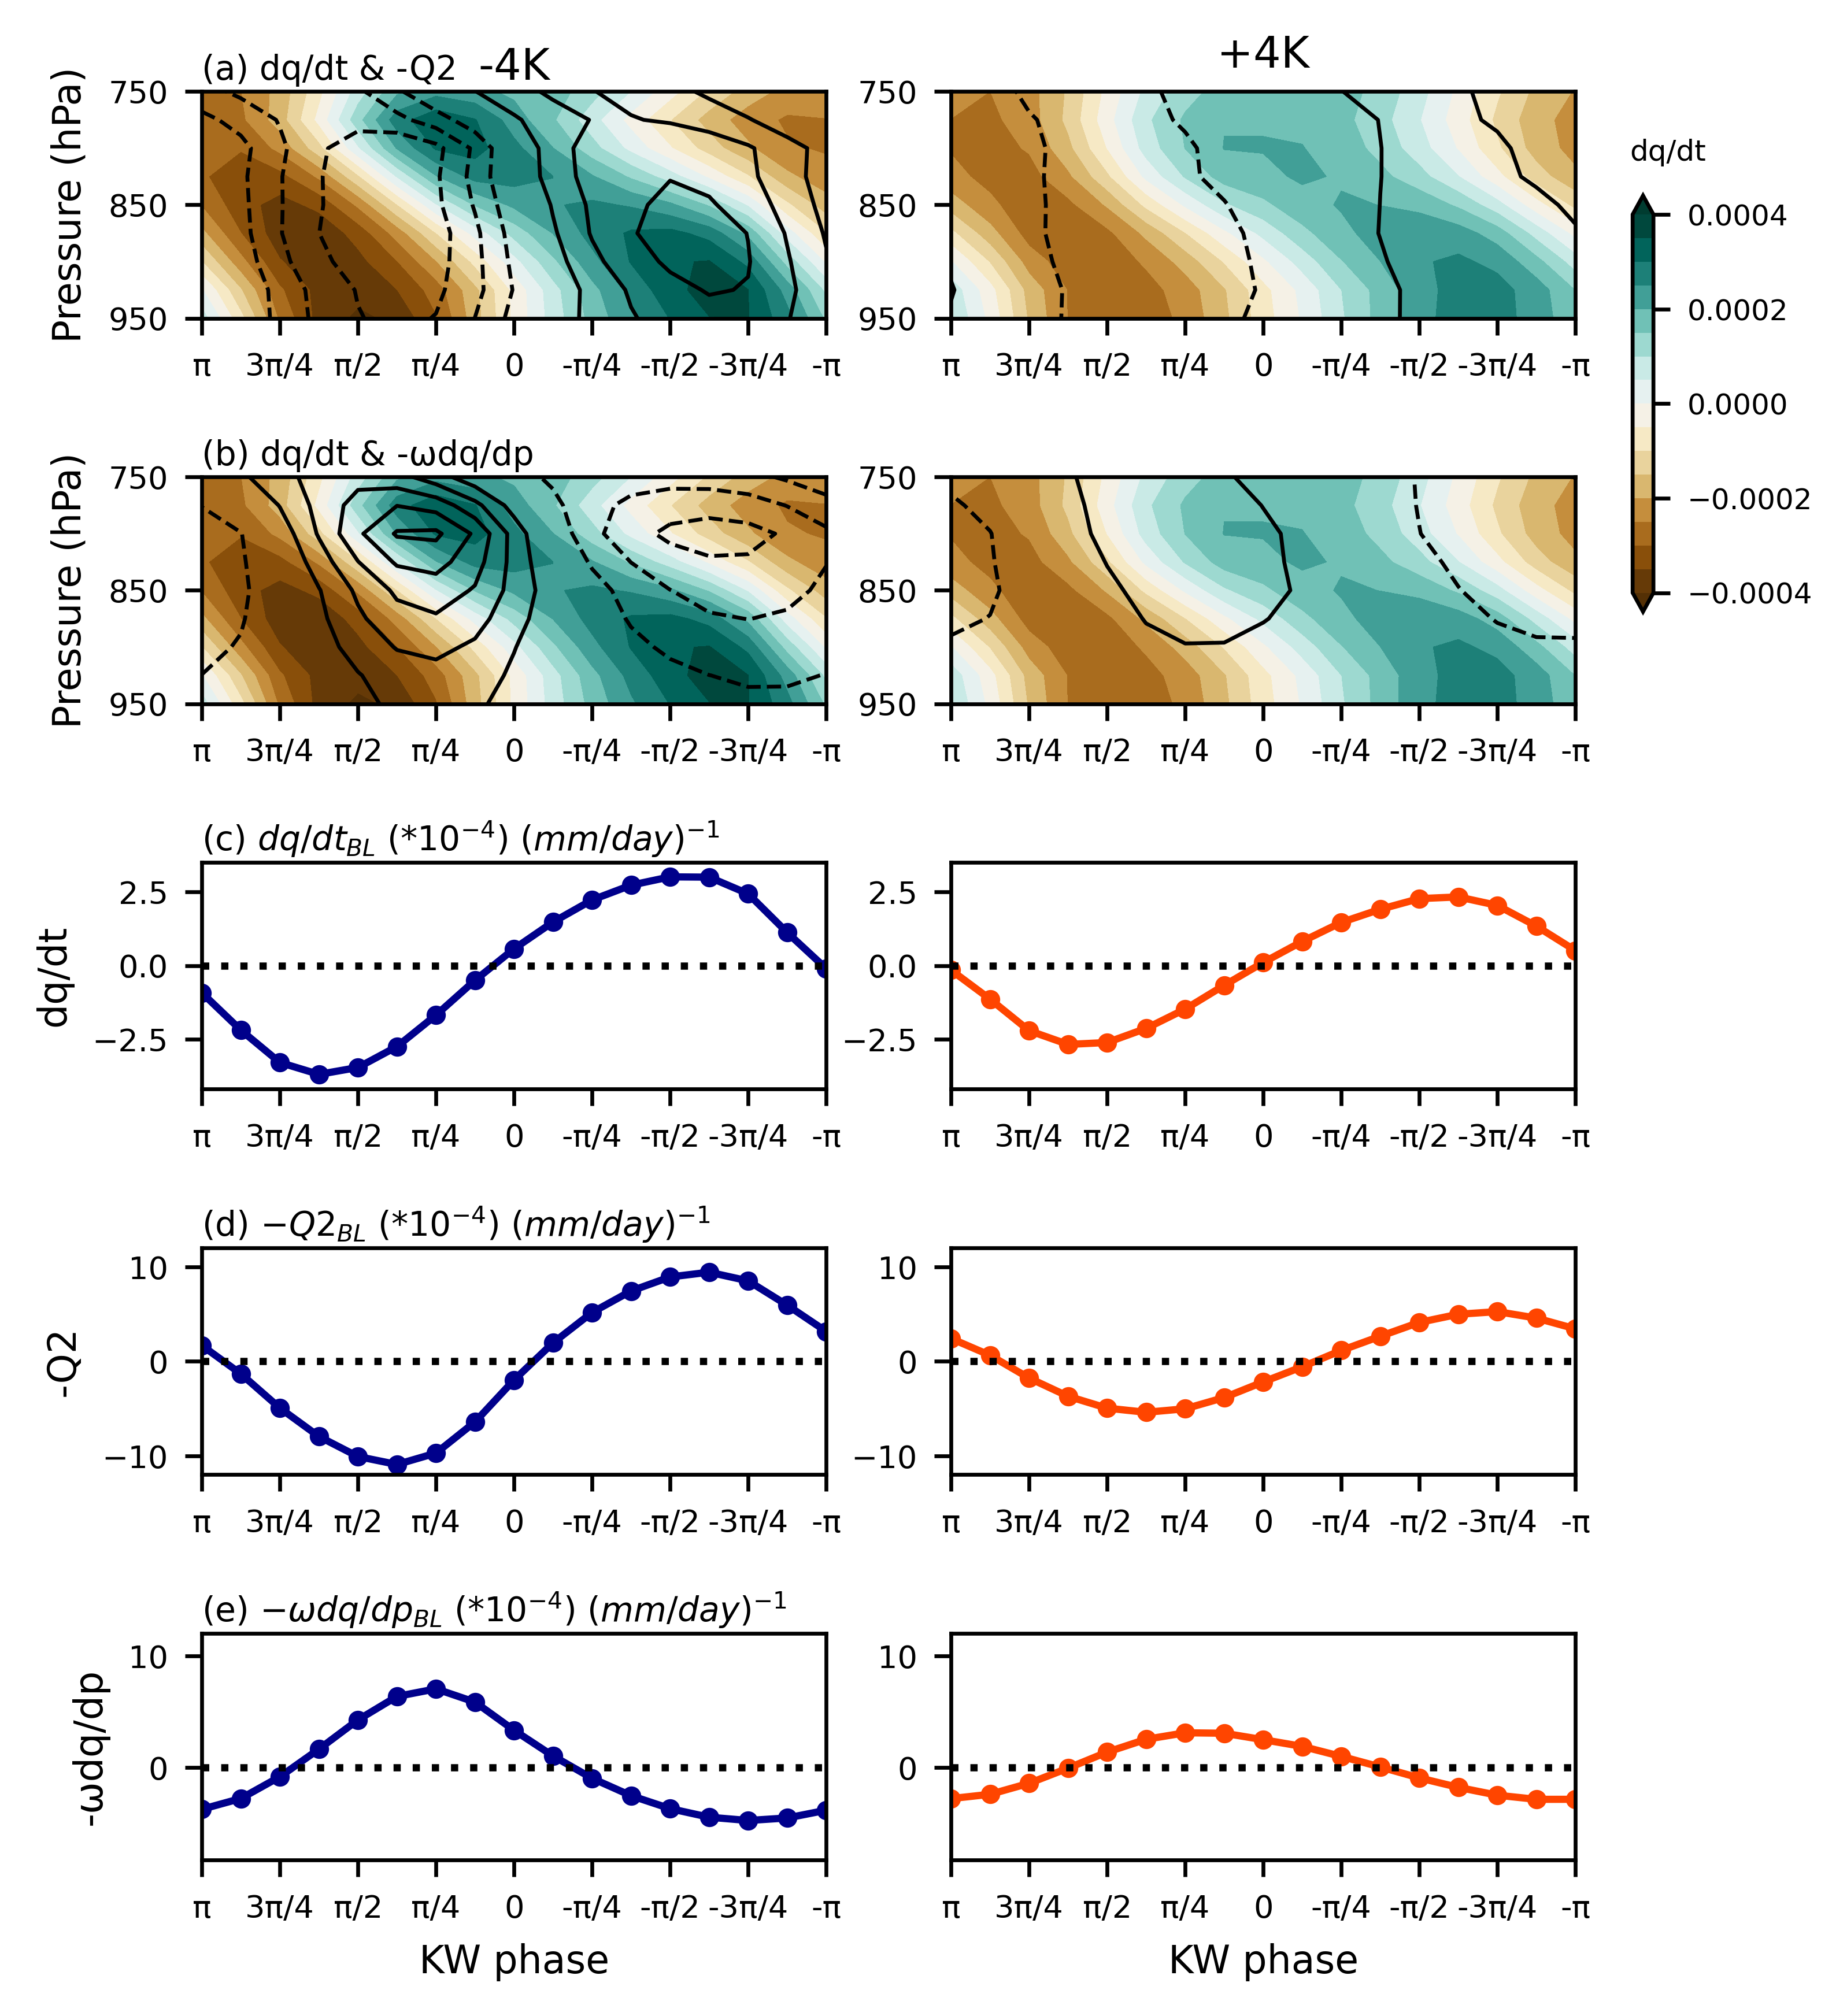

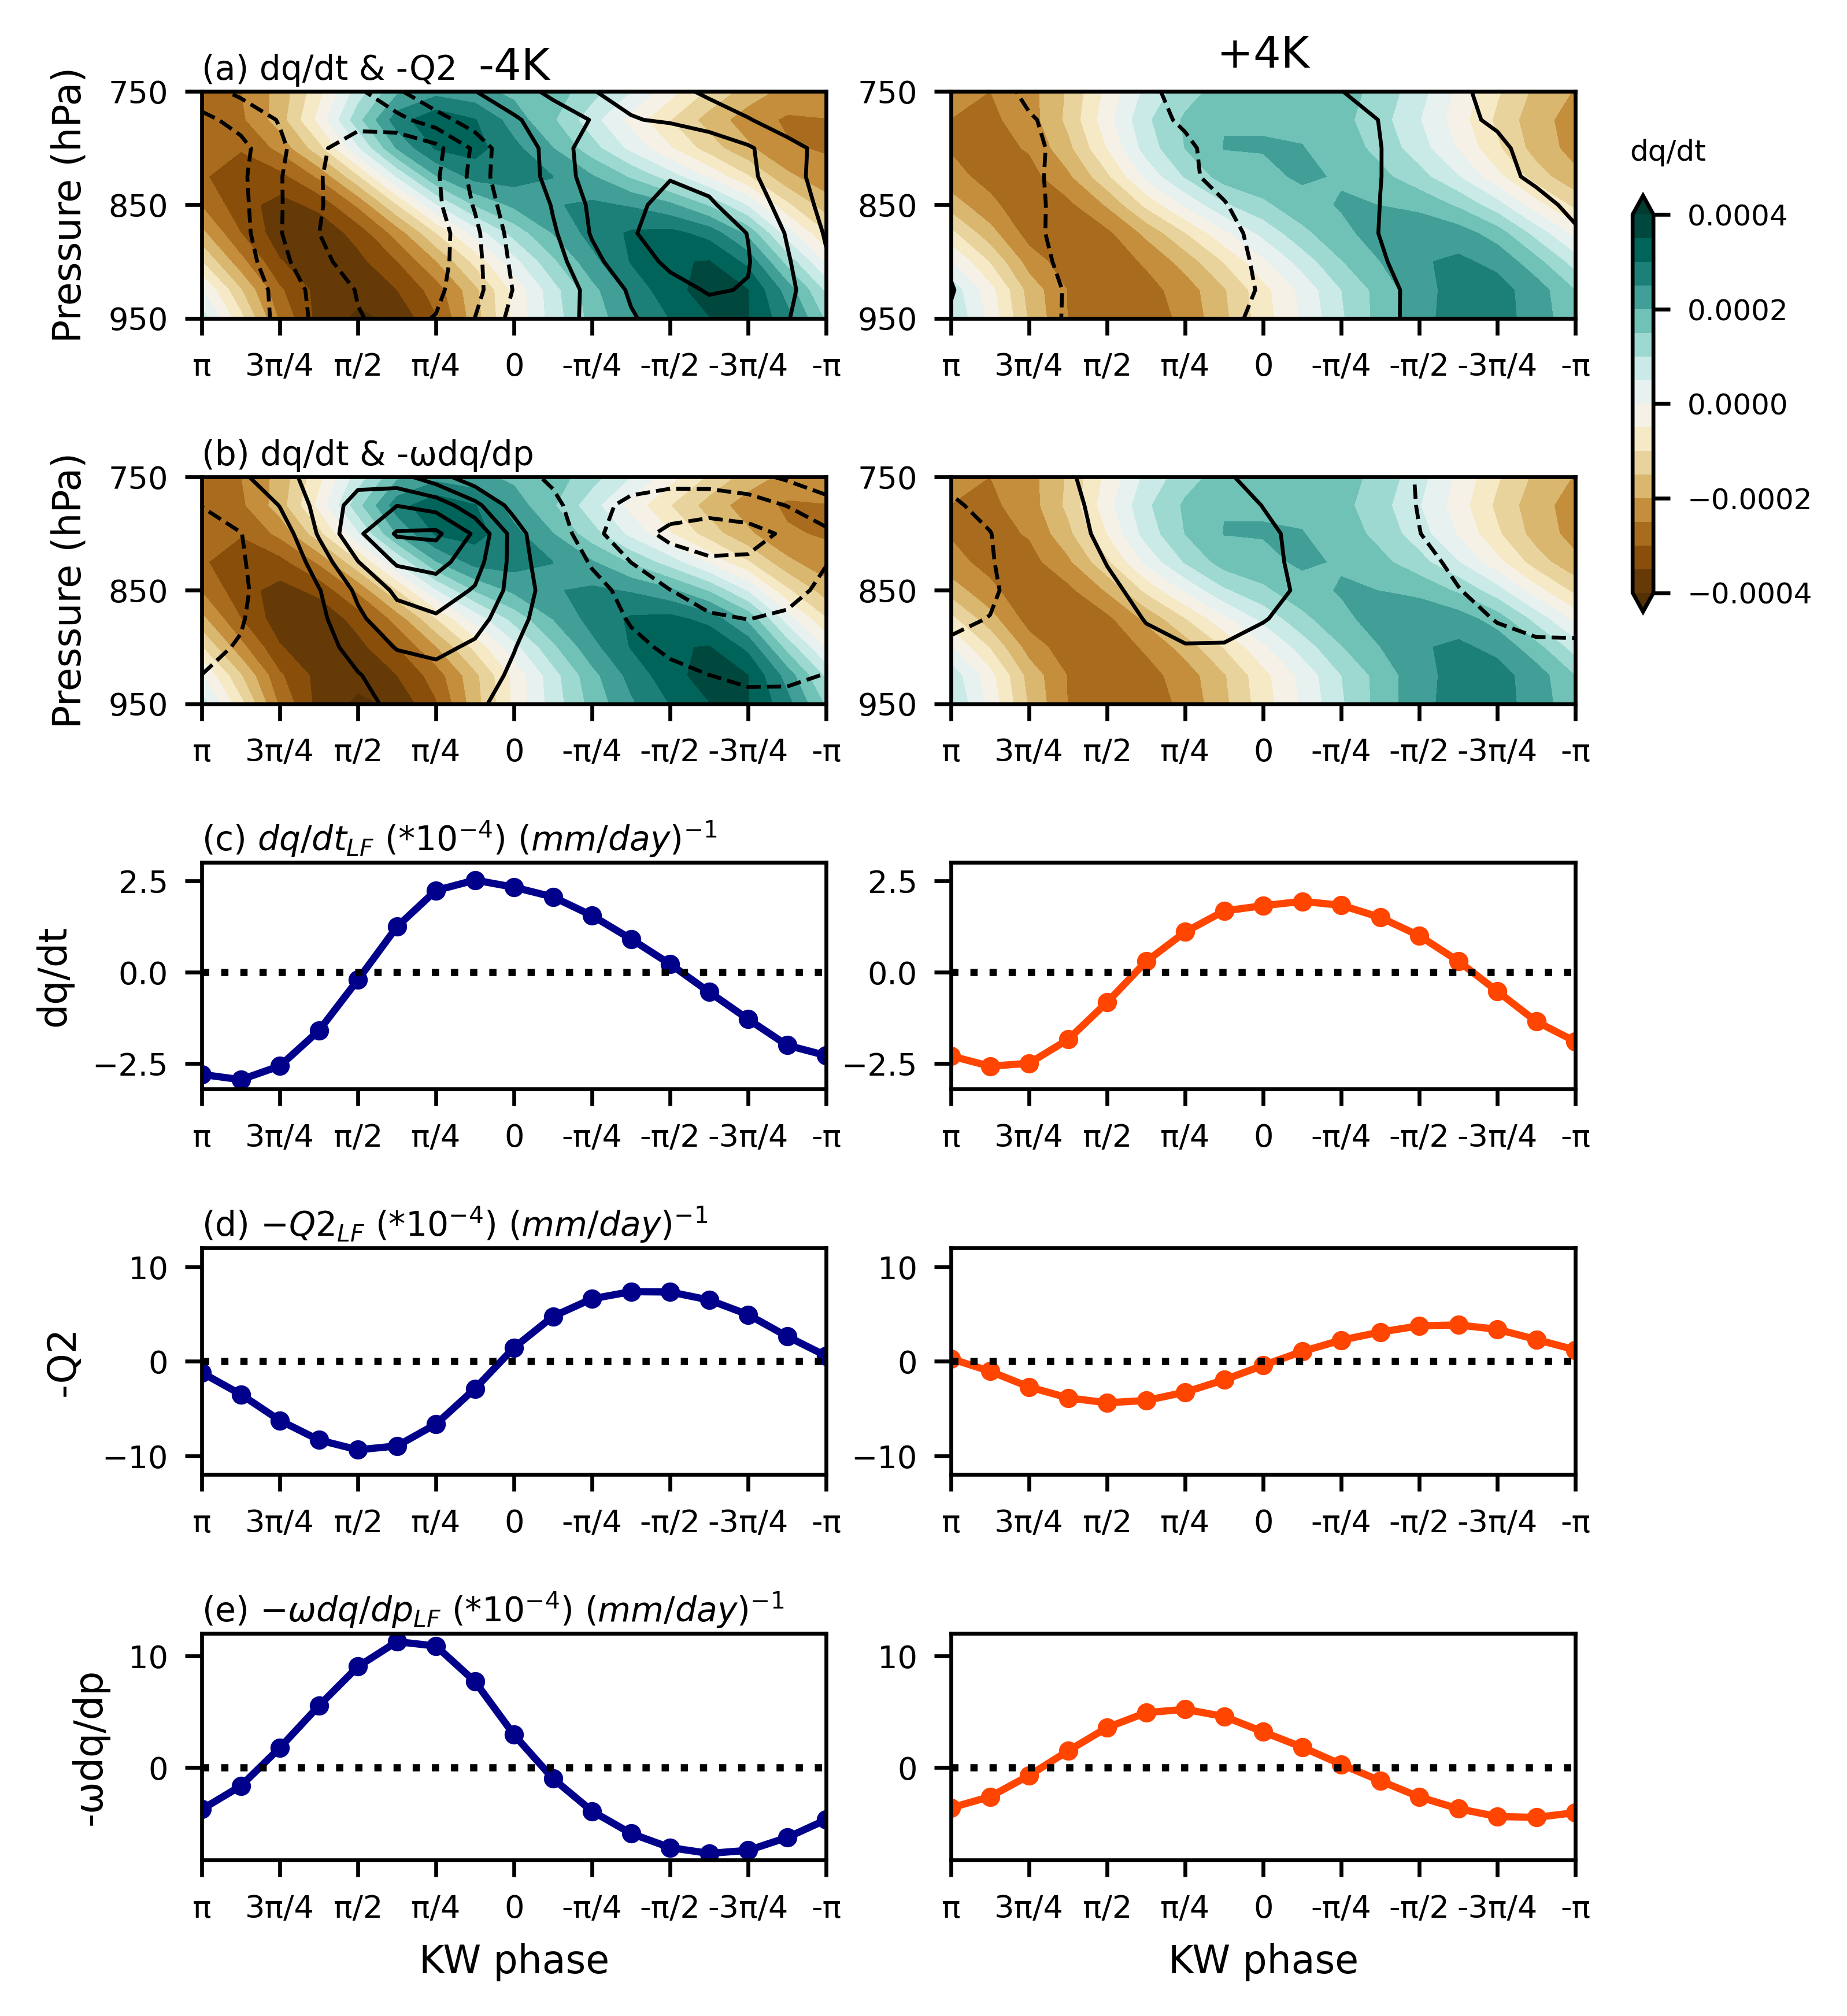

plot T2
plot T2


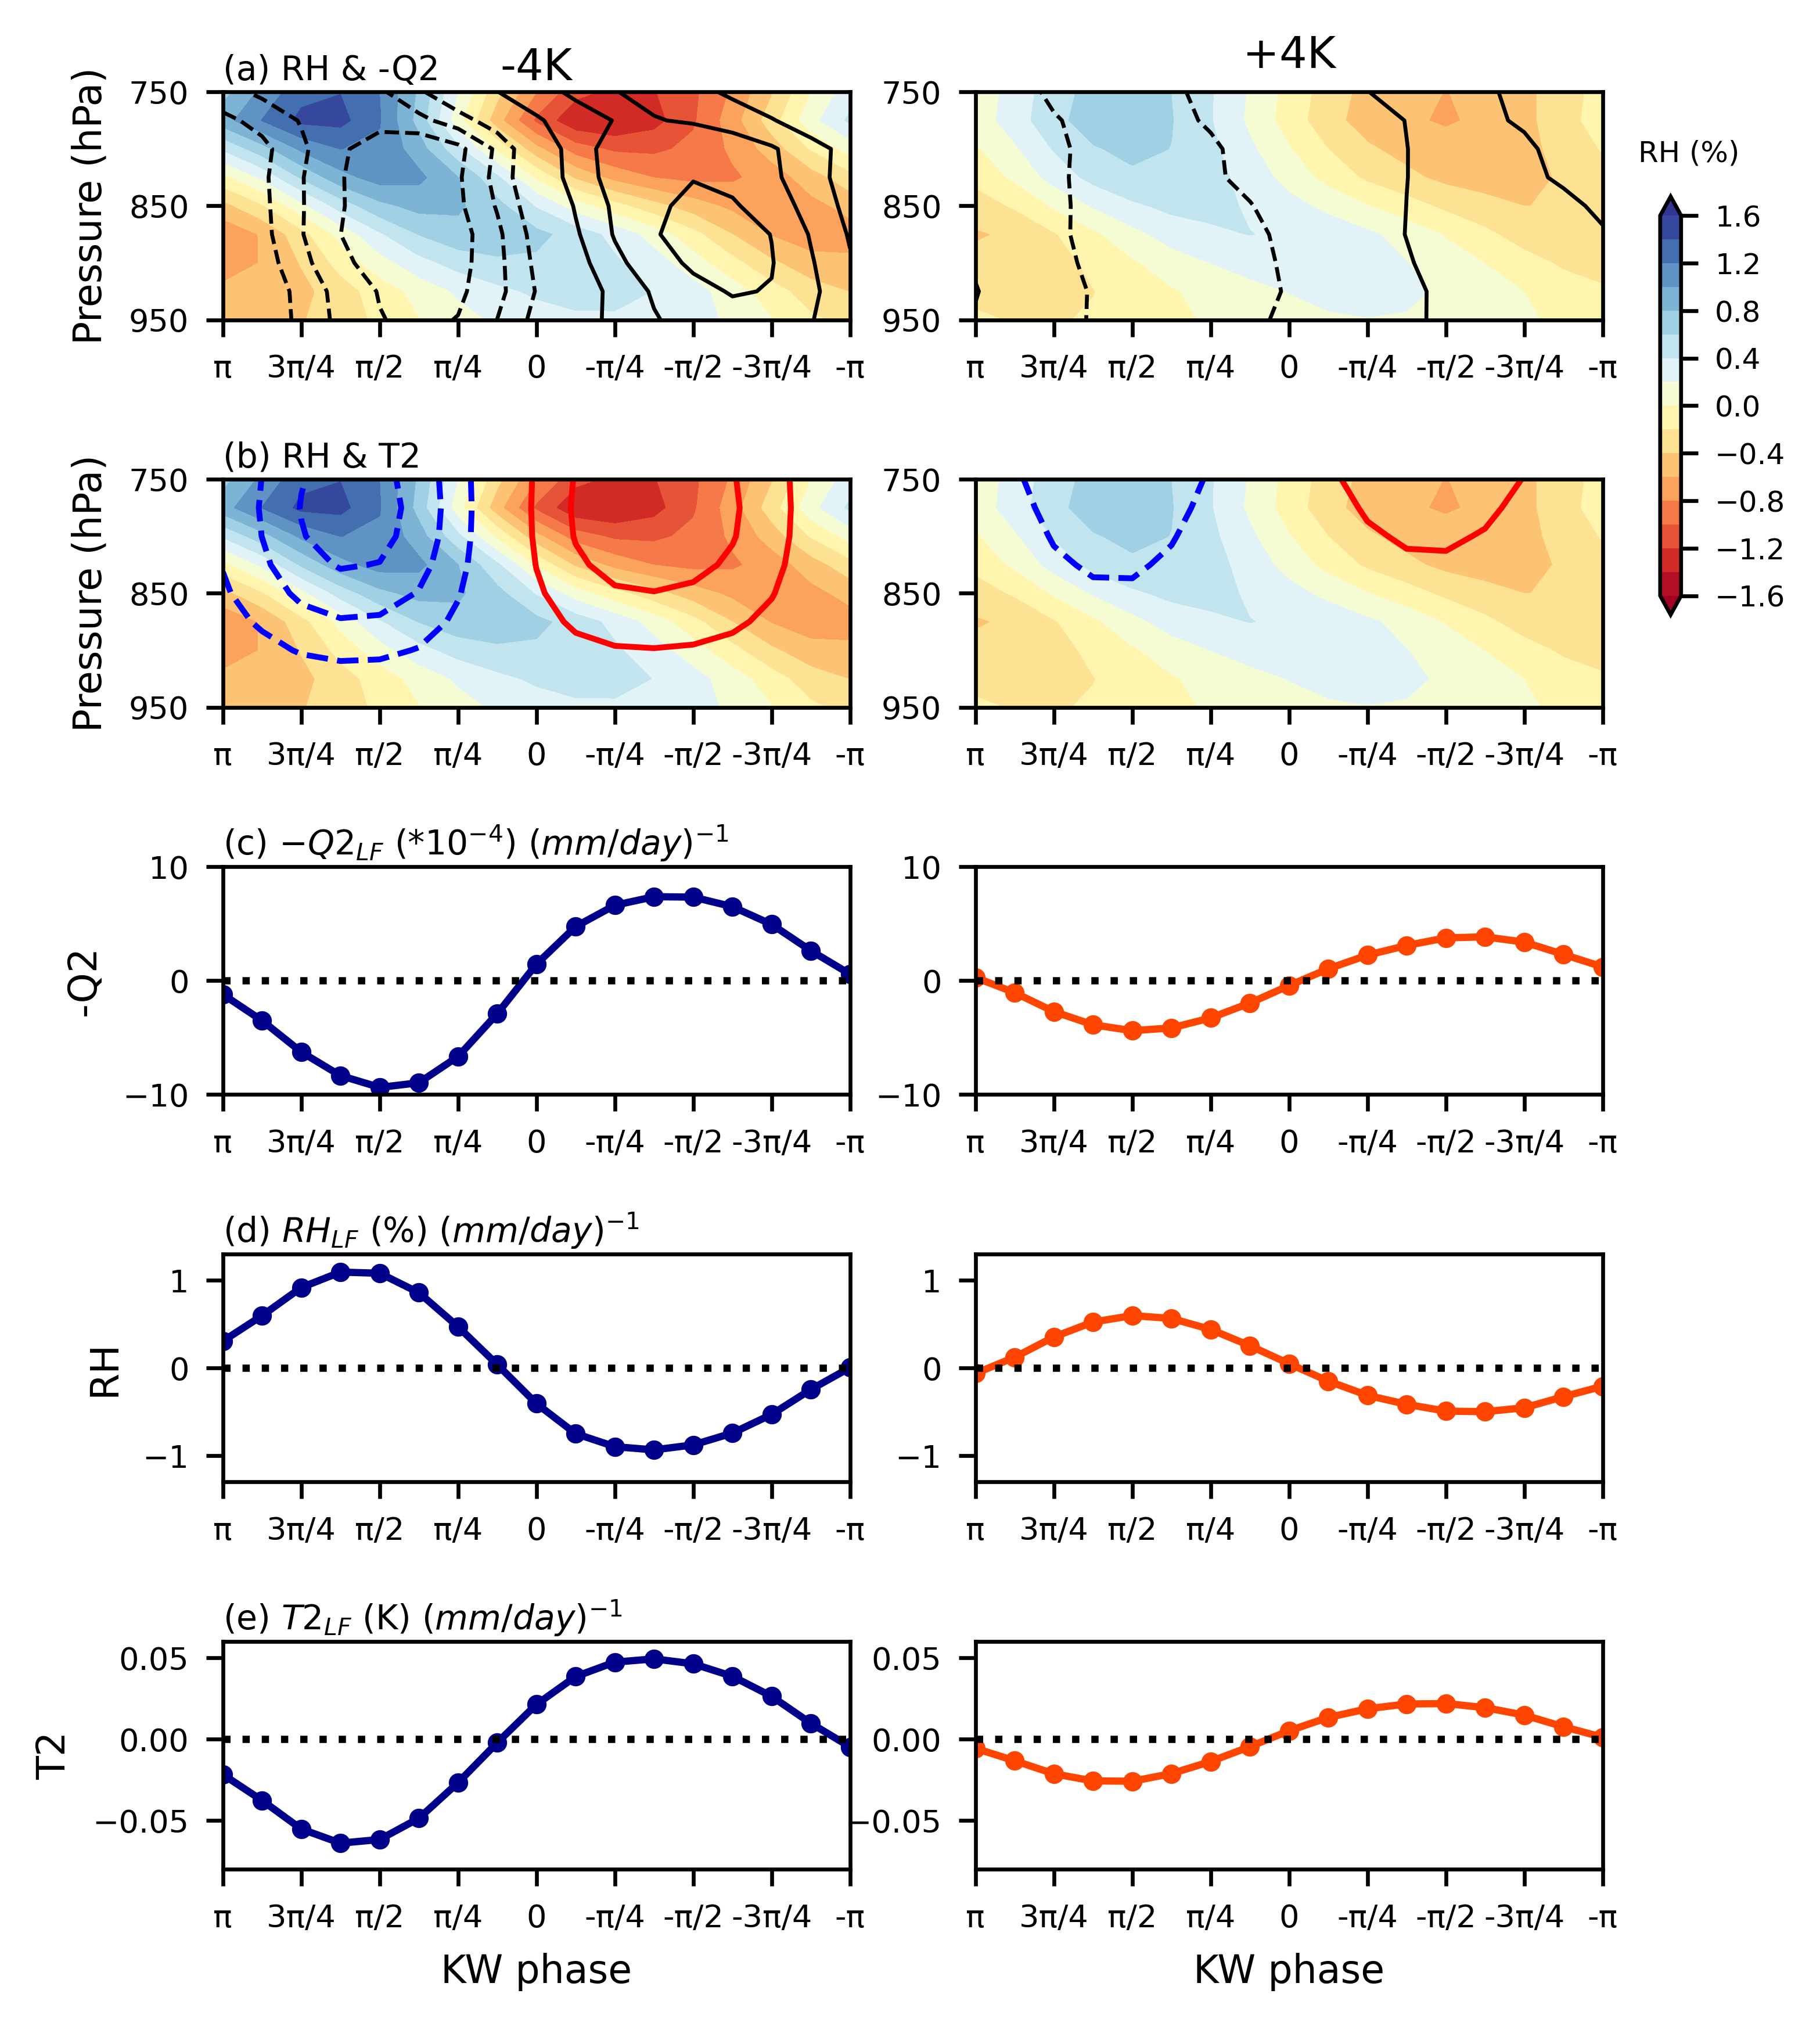

plot T2
plot T2


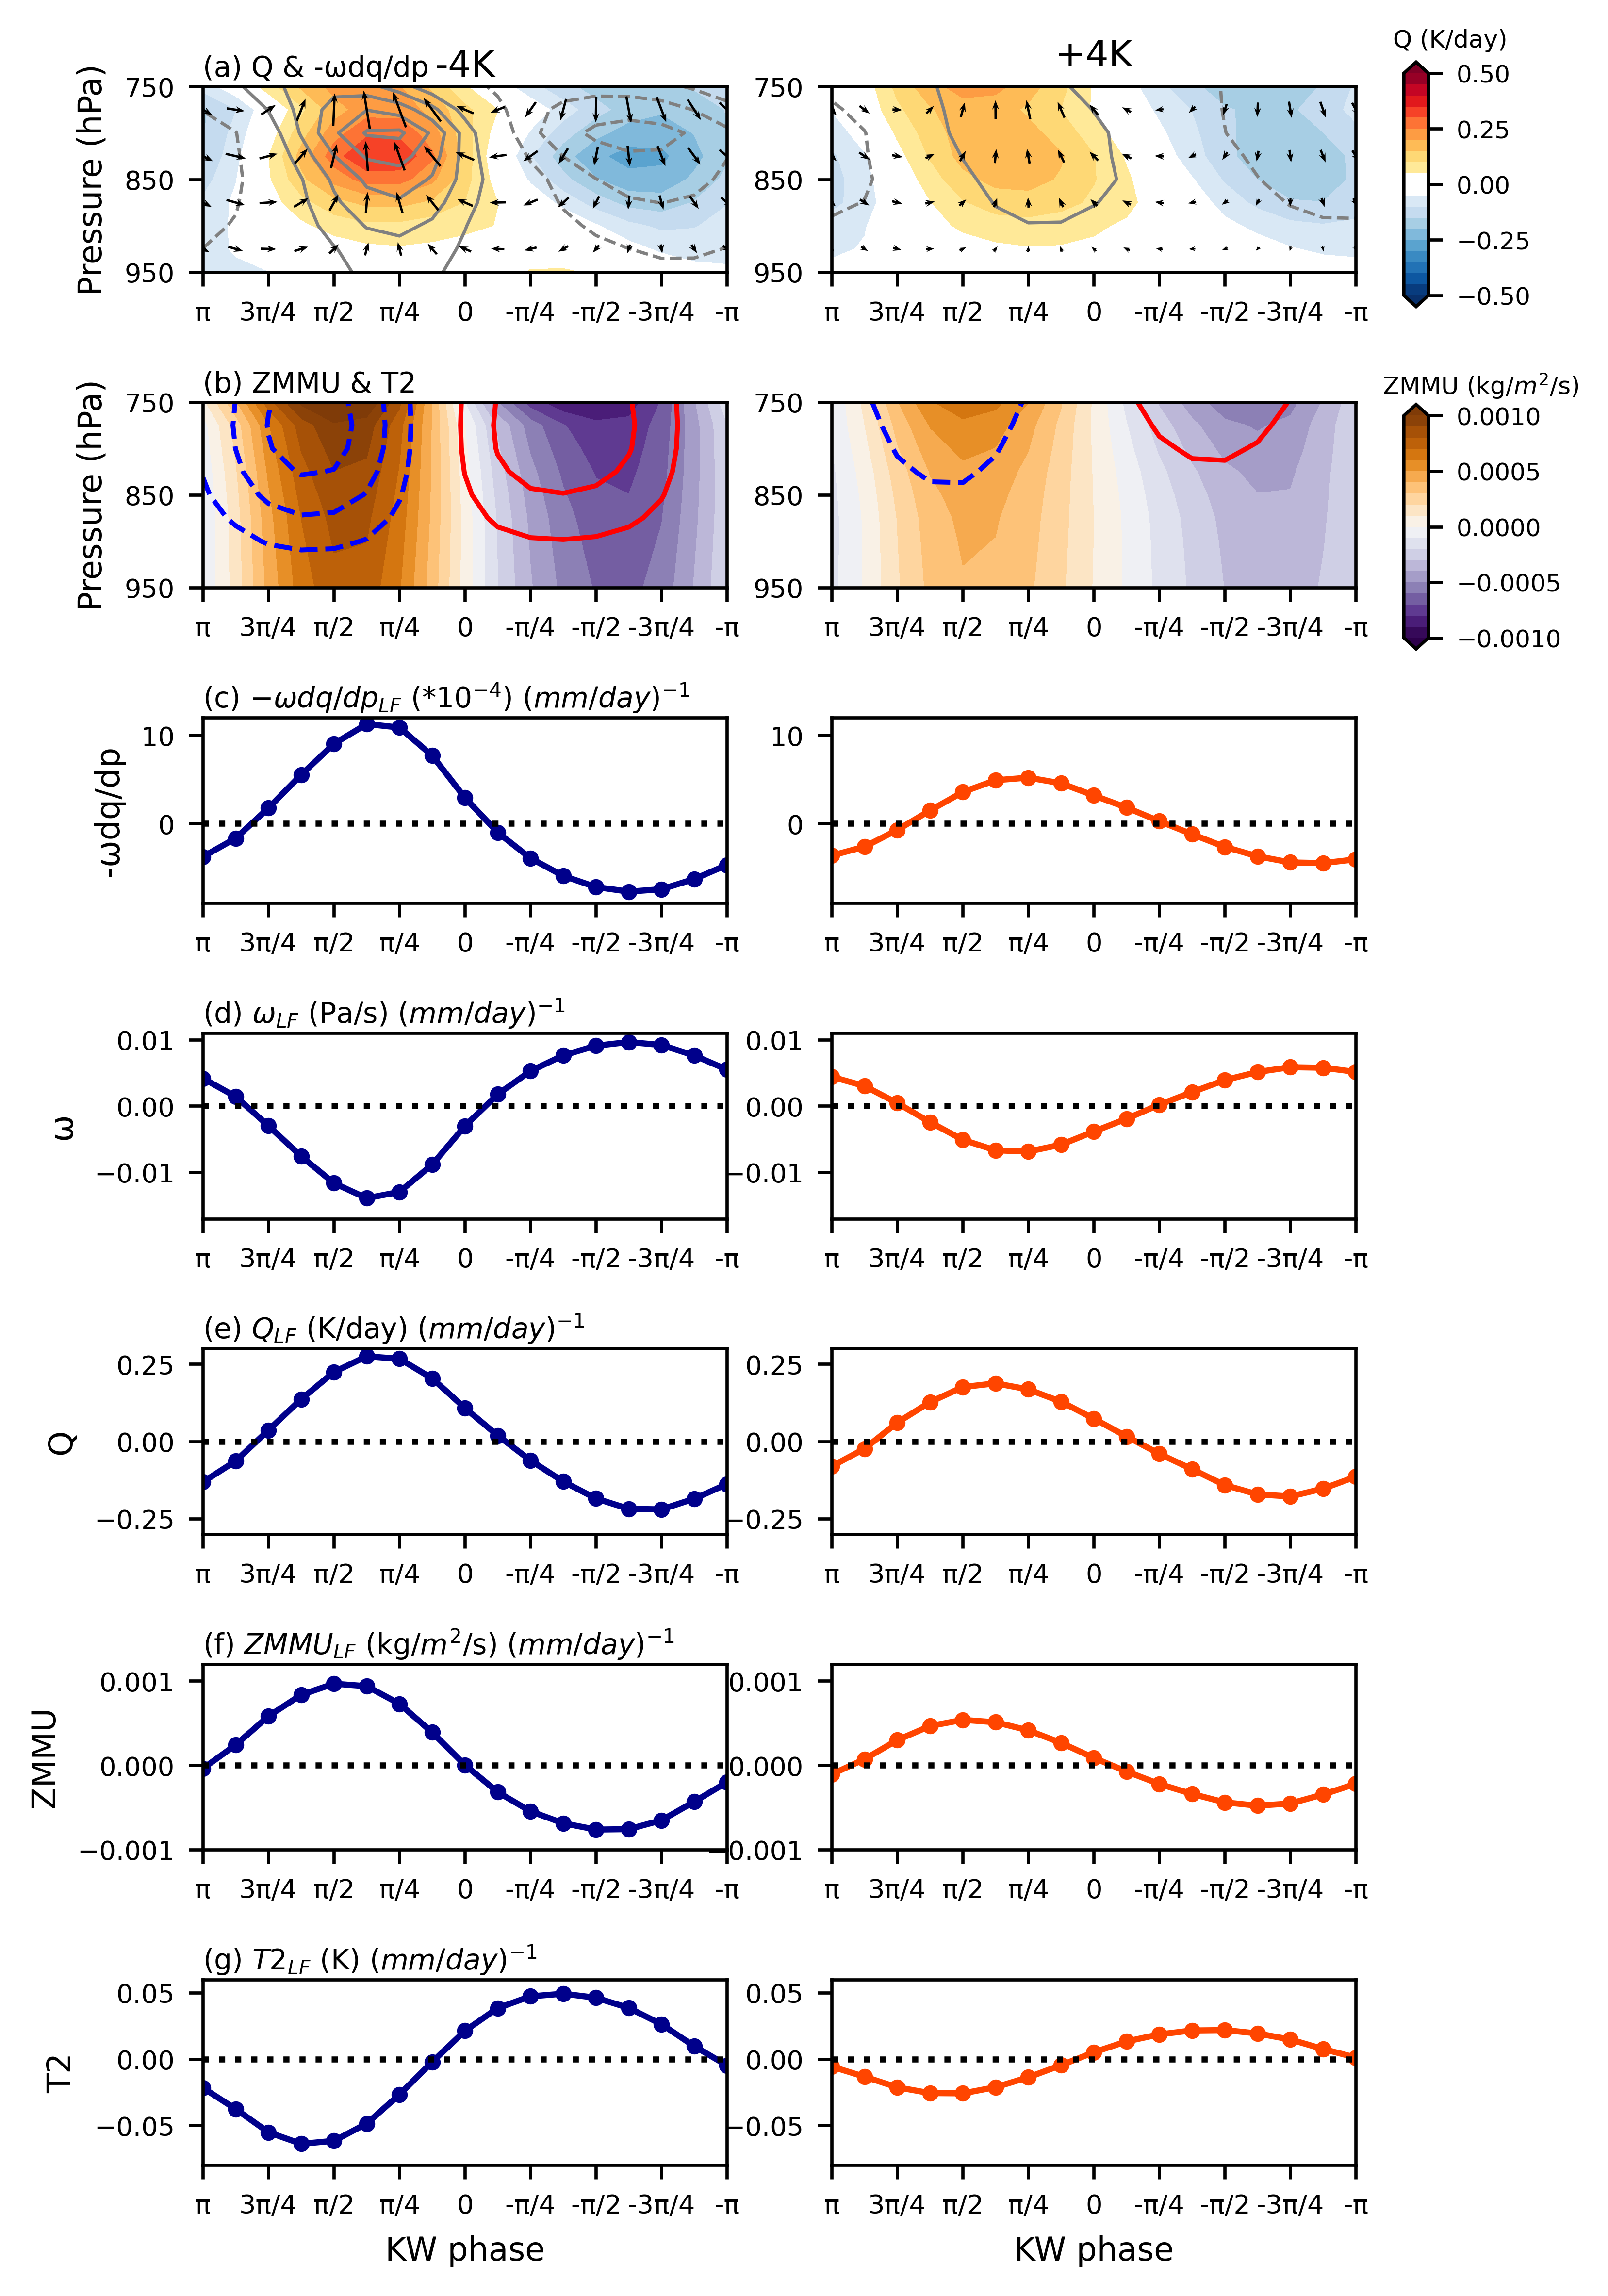

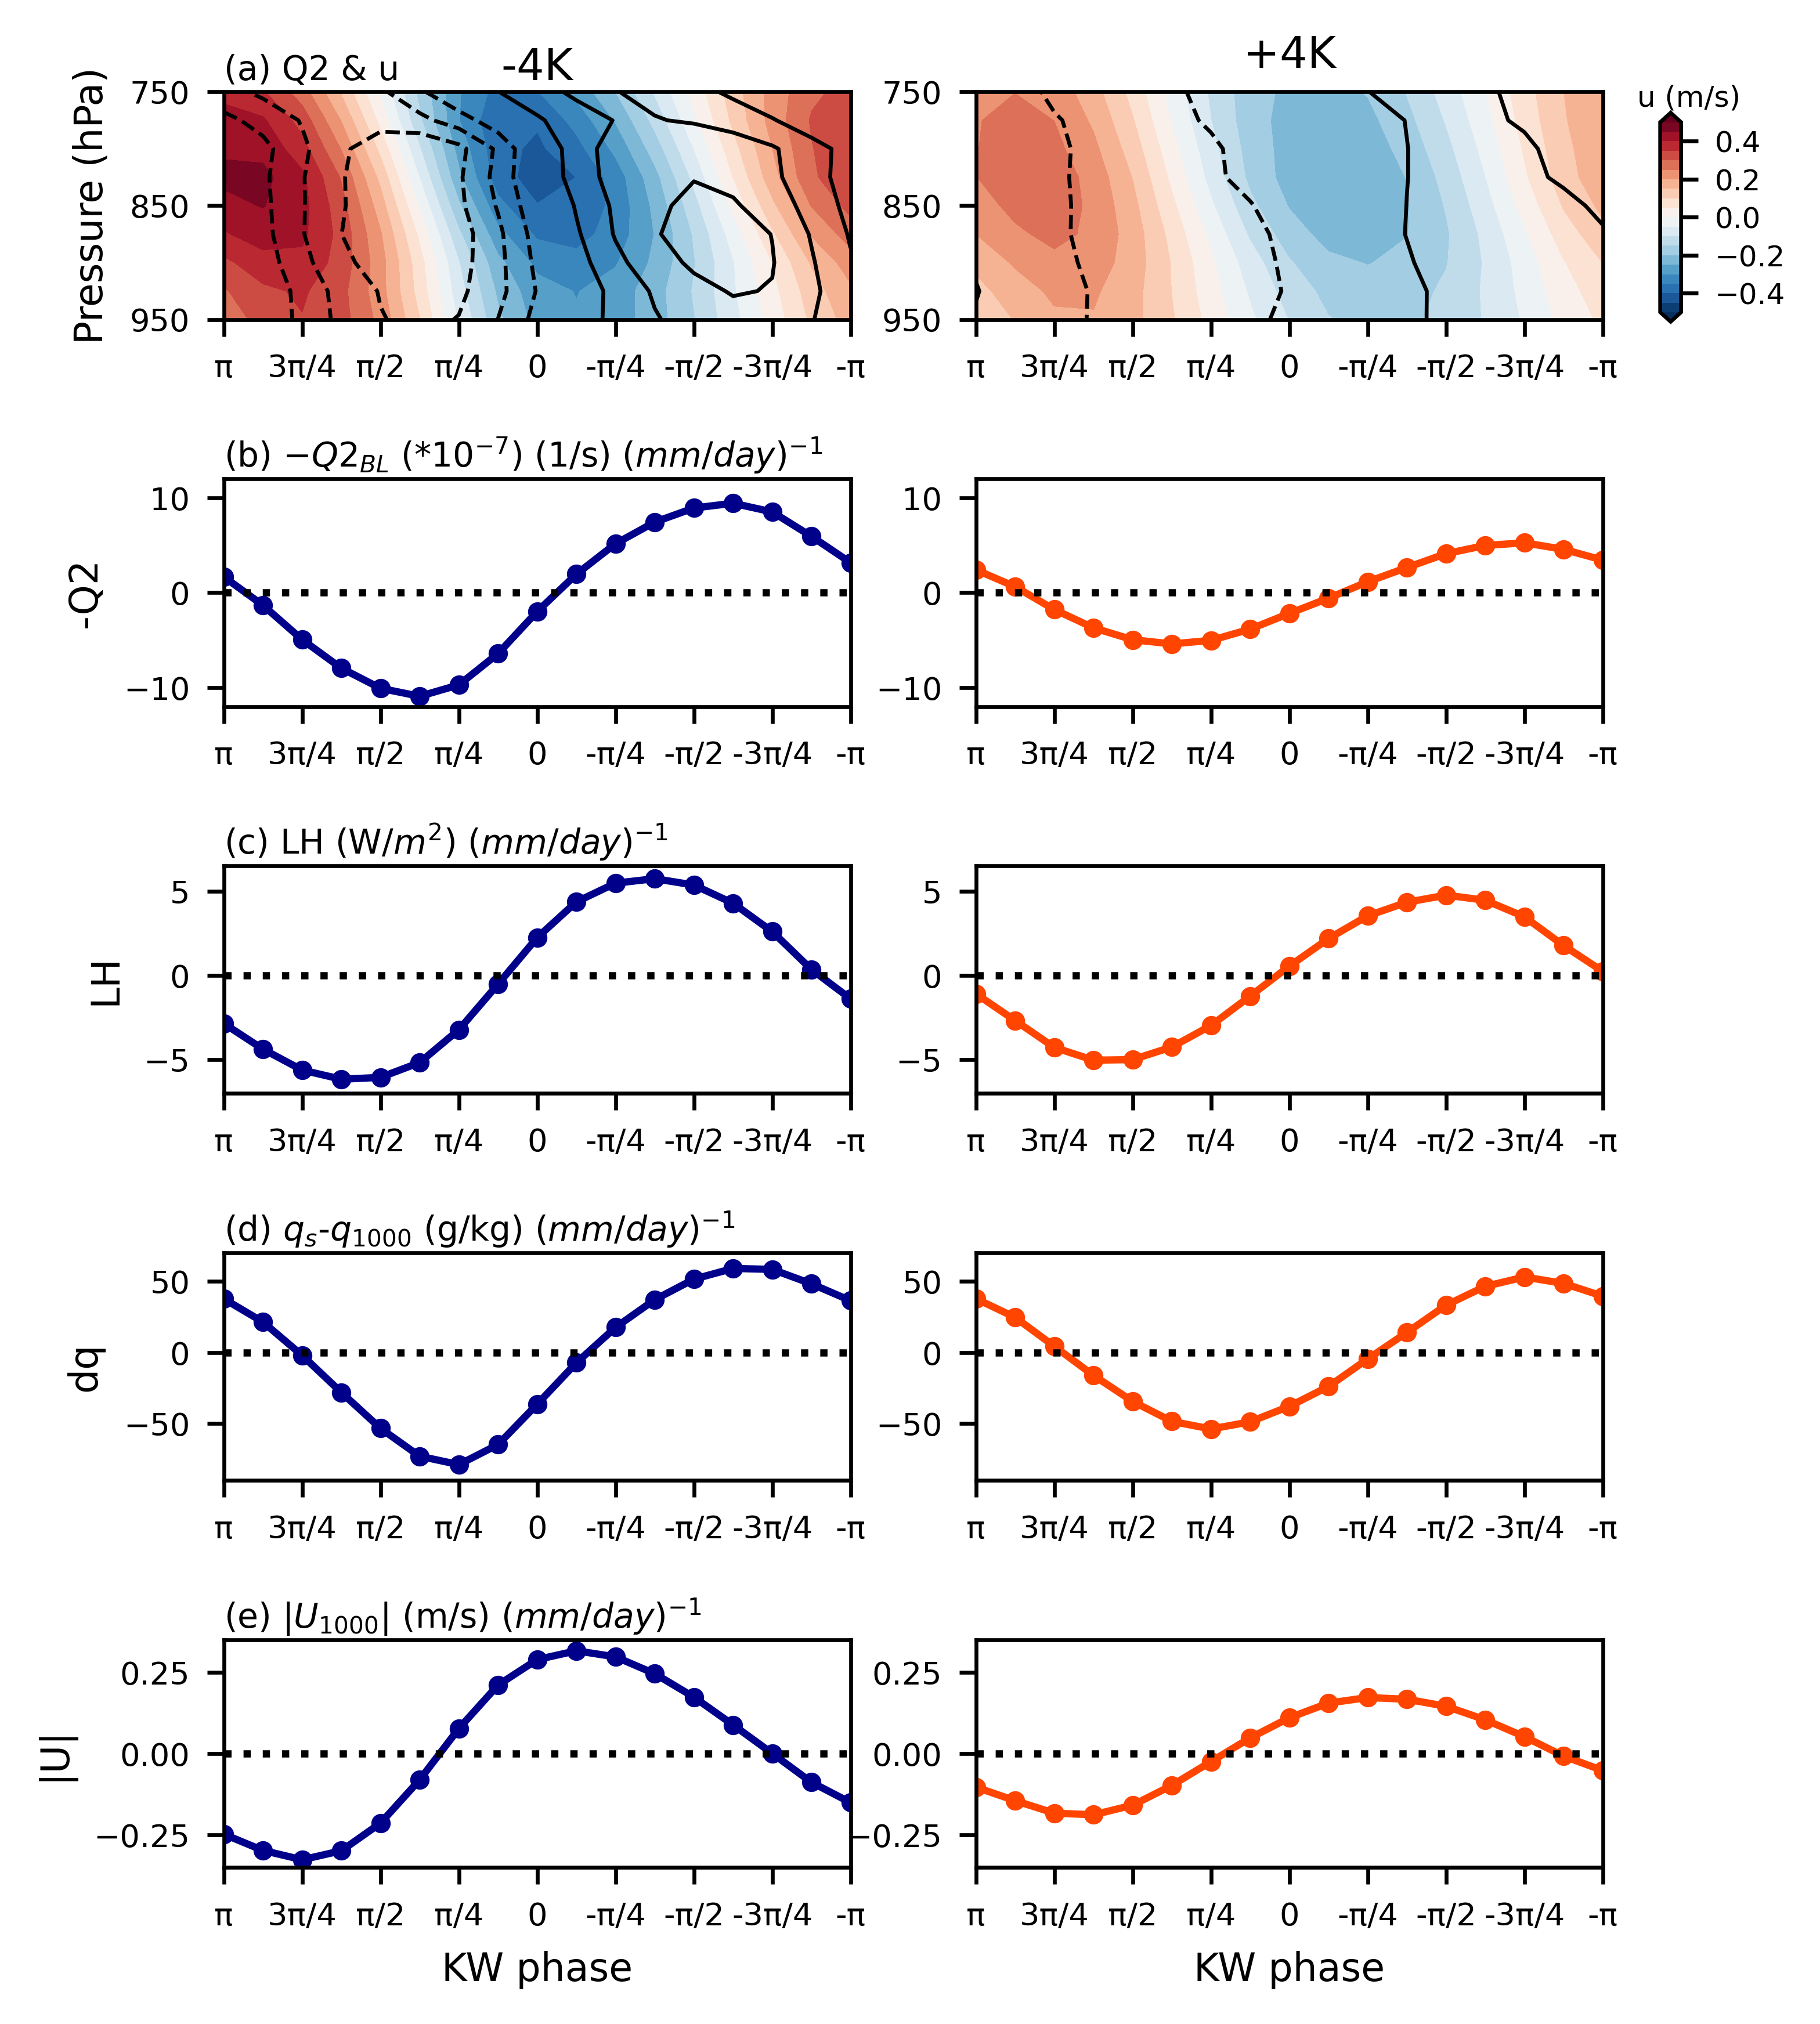

In [41]:
#######################################
# PLot vertical structure and line plots together
# 2024.7.24
###############################################
# Load KW composite q from aqua simulation
plot_colorbar = 0

color_list = list(['darkblue','green','orangered'])
plev_plot_min = 750 #400
plev_int = 100 #50 #100


title = list(['-4K', '+4K'])
icase_real = np.array([0,2])
font = 8
pltnum = np.size(title)

cmap_list = list(['BrBG','BrBG','RdYlBu','PuOr_r','RdBu_r',\
                 'RdBu_r'])
zero = np.zeros([nphase])

pltname = list(['dqdt_Q2_wdqdp_bl','dqdt_Q2_wdqdp_lf','Q2_RH_Tlf','wdqdp_w_zm-updraft_Q_vector','dudx_gph_T','Q2_LH_qbl'])
for ifig in range(0,6):
    if ifig == 4: #(dudx_gph_T figure is not used)
        continue
    
    if ifig != 3:
        nrow_total = 5
        fig,axes = plt.subplots(nrow_total,pltnum,figsize=(5.5, 6),dpi=600)
        gs = fig.add_gridspec(nrow_total,pltnum,width_ratios=[1,1],height_ratios=[1,1,1,1,1])
        plt.subplots_adjust(left=0.13,right=0.85,top=0.95,bottom=0.1,wspace=0.2, hspace=0.7)
    else:
        nrow_total = 7
        fig,axes = plt.subplots(nrow_total,pltnum,figsize=(5.5, 8.4),dpi=600)
        gs = fig.add_gridspec(nrow_total,pltnum,width_ratios=[1,1],height_ratios=[1,1,1,1,1,1,1])
        plt.subplots_adjust(left=0.13,right=0.85,top=0.95,bottom=0.1,wspace=0.2, hspace=0.7)        
    plt.rcParams.update({'font.size': font})

    if ifig == 0 or ifig == 1:
        clev    = np.arange(-4,4.5,0.5)*10**(-4) # dqdt
        clev1_n = np.arange(-15,0,3)*10**(-4) # Q2
        clev1_p = np.arange(3,18,3)*10**(-4) # Q2
        clev2_n = clev1_n # wdqdp
        clev2_p = clev1_p # wdqdp      
    elif ifig == 2:
        clev = np.arange(-1.6,1.8,0.2) # rh
        clev1_n = np.arange(-15,0,3)*10**(-4) # Q2
        clev1_p = np.arange(3,18,3)*10**(-4) # Q2  
        clev2_n_T = np.arange(-0.2,0,0.02) # T2
        clev2_p_T = np.arange(0.02,0.22,0.02) # T2
    elif ifig == 3:
        clev = np.arange(-0.5,0.55,0.05) # Q
        clev2 = np.arange(-1,1.1,0.1)*10**(-3) # ZMMU
        clev1_n = np.arange(-15,0,3)*10**(-4) # wdqdp
        clev1_p = np.arange(3,18,3)*10**(-4) # wdqdp   
        clev2_n_T = np.arange(-0.2,0,0.02) # T2
        clev2_p_T = np.arange(0.02,0.22,0.02) # T2
    elif ifig == 4:
        clev = np.arange(-1.2,1.4,0.2) #gph
        clev1_n = np.arange(-6,0,2)*10**(-7) # dudx
        clev1_p = np.arange(2,8,2)*10**(-7) # dudx 
        clev2_n = np.arange(-0.2,0,0.04) # T
        clev2_p = np.arange(0.04,0.24,0.04) # T
    elif ifig == 5:
        clev1_n = np.arange(-15,0,3)*10**(-4) # Q2
        clev1_p = np.arange(3,18,3)*10**(-4) # Q2 
        clev = np.arange(-0.5,0.55,0.05) # u
        #plot u w as arrow
    
    if ifig == 0 or ifig == 1:   
        if ifig == 0:
            fig_name = 'Fig.S3_KW_composite_'+pltname[ifig]+'.png'
            title_list = list(['(a) dq/dt & -Q2','(b) dq/dt & -\u03C9dq/dp','(c) $dq/dt_{BL}$ (*$10^{-4}$) $({mm/day})^{-1}$',\
                           '(d) $-Q2_{BL}$ (*$10^{-4}$) $({mm/day})^{-1}$', '(e) $-\u03C9dq/dp_{BL}$ (*$10^{-4}$) $({mm/day})^{-1}$'])
            vlist      = list(['dqdt_bl_KW','Q2_bl_KW','wdqdp_bl_KW'])
        else:
            fig_name = 'Fig.7_KW_composite_'+pltname[ifig]+'.png'
            title_list = list(['(a) dq/dt & -Q2','(b) dq/dt & -\u03C9dq/dp','(c) $dq/dt_{LF}$ (*$10^{-4}$) $({mm/day})^{-1}$',\
                           '(d) $-Q2_{LF}$ (*$10^{-4}$) $({mm/day})^{-1}$', '(e) $-\u03C9dq/dp_{LF}$ (*$10^{-4}$) $({mm/day})^{-1}$'])
            vlist      = list(['dqdt_lf_KW','Q2_lf_KW','wdqdp_lf_KW'])            
        vlist_cf   = list(['dqdt_KW','dqdt_KW'])
        vlist_cn   = list(['Q2moist_KW','wdqdp_KW'])
        ylabel_list = list(['dq/dt','-Q2','-\u03C9dq/dp'])
        if ifig == 0:
            ymax = np.array([3.5, 12, 12])
            ymin = np.array([-4.2, -12, -8.3])
        else:
            ymax = np.array([3, 12, 12])
            ymin = np.array([-3.2, -12, -8.3])         
        is_dqdt_cf = np.array([1,1])
        is_dqdt_cn = np.array([1,1])
        is_dqdt_line = np.array([1,1,1])
        is_rh_line = np.array([0,0,0])
        is_rh_cf = np.array([0,0])
        ticks = np.arange(-4,6,2)*10**(-4)
    elif ifig == 2:
        fig_name = 'Fig.8_KW_composite_'+pltname[ifig]+'.png'
        title_list = list(['(a) RH & -Q2','(b) RH & T2','(c) $-Q2_{LF}$ (*$10^{-4}$) $({mm/day})^{-1}$',\
                           '(d) $RH_{LF}$ (%) $({mm/day})^{-1}$', '(e) $T2_{LF}$ (K) $({mm/day})^{-1}$'])
        vlist      = list(['Q2_lf_KW','rh_lf_KW','T2_lf_KW'])
        vlist_cf   = list(['rh_KW','rh_KW'])
        vlist_cn   = list(['Q2moist_KW','T2_KW'])
        ylabel_list = list(['-Q2','RH','T2'])
        #ymax = np.array([10, 1.3, 0.1])
        ymax = np.array([10, 1.3, 0.06])
        ymin = np.array([-10,-1.3,-0.08])
        is_rh_cf = np.array([1,1])
        is_rh_line = np.array([0,1,0])
        is_dqdt_cf = np.array([0,0])
        is_dqdt_cn = np.array([1,0])
        is_dqdt_line = np.array([1,0,0])
        ticks = np.arange(-1.6,2,0.4)
    elif ifig == 3:
        fig_name = 'Fig.9_KW_composite_'+pltname[ifig]+'.png'
        title_list = list(['(a) Q & -\u03C9dq/dp','(b) ZMMU & T2','(c) $-\u03C9dq/dp_{LF}$ (*$10^{-4}$) $({mm/day})^{-1}$',\
                           '(d) $\u03C9_{LF}$ (Pa/s) $({mm/day})^{-1}$', '(e) $Q_{LF}$ (K/day) $({mm/day})^{-1}$',\
                           '(f) $ZMMU_{LF}$ (kg/$m^{2}$/s) $({mm/day})^{-1}$', '(g) $T2_{LF}$ (K) $({mm/day})^{-1}$'])
        vlist      = list(['wdqdp_lf_KW','w_lf_KW','Q_lf_KW','ZMMU_lf_KW','T2_lf_KW'])
        vlist_cf = list(['Q_KW','ZMMU_KW'])
        vlist_cn = list(['wdqdp_KW','T2_KW'])
        ylabel_list = list(['-\u03C9dq/dp','\u03C9','Q','ZMMU','T2'])
        ymax = np.array([12, 0.011, 0.3, 0.0012, 0.06])
        ymin = np.array([-9, -0.017,-0.3, -0.001,  -0.08])
        is_rh_cf = np.array([0,0])
        is_rh_line = np.array([0,0,0,0,0])
        is_dqdt_cf = np.array([0,0])
        is_dqdt_cn = np.array([1,0])
        is_dqdt_line = np.array([1,0,0,0,0])
        ticks = np.arange(-0.5,0.75,0.25) # Q
        ticks2 = np.arange(-1,1.5,0.5)*10**(-3) # ZMMU
    elif ifig == 4:
        print('Not used for final paper')
    elif ifig == 5:
        fig_name = 'Fig.S4_KW_composite_'+pltname[ifig]+'.png'
        title_list = list(['(a) Q2 & u',\
                           '(b) $-Q2_{BL}$ (*$10^{-7}$) (1/s) $({mm/day})^{-1}$', '(c) LH (W/$m^{2}$) $({mm/day})^{-1}$',\
                           '(d) $q_{s}$-$q_{1000}$ (g/kg) $({mm/day})^{-1}$','(e) |$U_{1000}$| (m/s) $({mm/day})^{-1}$'])
        vlist      = list(['Q2_bl_KW','LH_KW','q1000_KW','uspeed_1000_KW'])
        vlist_cf   = list(['u_KW'])
        vlist_cn   = list(['Q2moist_KW'])
        ylabel_list = list(['-Q2','LH','dq','|U|'])
        ymax = np.array([12, 6.5, 70, 0.35])
        ymin = np.array([-12, -7, -90,-0.35])
        is_rh_cf = np.array([0])
        is_rh_line = np.array([0,0,0,0])
        is_dqdt_cf = np.array([0])
        is_dqdt_cn = np.array([1])
        is_dqdt_line = np.array([1,0,0,0])
        ticks = np.arange(-0.4,0.6,0.2)
        
    xx, yy = np.meshgrid(phase,plev)   

    if ifig !=5:
        nrow = 2
    elif ifig == 5:
        nrow = 1
    nrow_lineplot = nrow_total-nrow
    
    # Row 1 and 2
    for irow in range(0,nrow):
        VAR_cf = globals()[vlist_cf[irow]+'_all']
        VAR_cn = globals()[vlist_cn[irow]+'_all']
        VAR_cn_T = globals()['T2_KW_all']
        # Change unit:
        if is_dqdt_cf[irow] == 1:
            VAR_cf = VAR_cf*freq_ave*s2d
        if is_dqdt_cn[irow] == 1:
            VAR_cn = VAR_cn*freq_ave*s2d   
        if is_rh_cf[irow] == 1:
            VAR_cf = VAR_cf*100
        
        # Assign contour level:
        if irow == 0:
            clev_p = clev1_p
            clev_n = clev1_n
        elif (irow==1 and ifig!=2) and (irow==1 and ifig!=3):
            clev_p = clev2_p
            clev_n = clev2_n

        # Plot
        for icase in range(0,pltnum):
            ax2  = fig.add_subplot(gs[ irow, icase ])
            ax = plt.gca()
            if irow == 0:
                plt.title(title[icase], pad=5, loc='center',fontsize=9)
            if icase == 0:
                plt.title(title_list[irow], pad=2.5, loc='left',fontsize=7)
            if ifig == 3 and irow == 0:
                cf  = plt.contourf(xx, yy, VAR_cf[:,:,icase_real[icase]].T, levels=clev, cmap=get_cmap(RWB), extend='both' )
            elif ifig == 3 and irow == 1:
                cf  = plt.contourf(xx, yy, VAR_cf[:,:,icase_real[icase]].T, levels=clev2, cmap=cmap_list[ifig], extend='both' )
            else:
                cf  = plt.contourf(xx, yy, VAR_cf[:,:,icase_real[icase]].T, levels=clev, cmap=cmap_list[ifig], extend='both' )
            if (ifig ==3 and irow == 1) or (ifig==2 and irow == 1):
                cn_p = plt.contour(xx, yy, VAR_cn_T[:,:,icase_real[icase]].T, levels=clev2_p_T, colors='r', \
                                   linewidths=1.2)
                cn_n = plt.contour(xx, yy, VAR_cn_T[:,:,icase_real[icase]].T, levels=clev2_n_T, colors='b', \
                                   linestyles='dashed',linewidths=1.2)                 
            if (ifig ==3 and irow == 1) or (ifig==2 and irow==1):
                print('plot T2')
            elif ifig == 3 and irow == 0:
                cn_p = plt.contour(xx, yy, VAR_cn[:,:,icase_real[icase]].T, levels=clev_p, zorder=1, colors='grey', linewidths=0.8)
                cn_n = plt.contour(xx, yy, VAR_cn[:,:,icase_real[icase]].T, levels=clev_n, zorder=1, colors='grey', linestyles='dashed',linewidths=0.8) 
                # Plot u, w in vector
                skip = (slice(None, None, 2), slice(None, None, 1))
                skip2 = (slice(None, None, 1), slice(None, None, 2))
                u_norm_tmp = u_norm[:,:,icase_real[icase]]
                w_norm_tmp = w_norm[:,:,icase_real[icase]]
                plt.quiver(xx[skip], yy[skip], u_norm_tmp[skip2].T, -w_norm_tmp[skip2].T,units='inches',scale=1.5*10**(-6), \
                           width=0.008, headwidth=3, headlength=4, headaxislength=3, zorder=2, color='k', pivot='middle')
            else:
                cn_p = plt.contour(xx, yy, VAR_cn[:,:,icase_real[icase]].T, levels=clev_p, colors='k', linewidths=0.8)
                cn_n = plt.contour(xx, yy, VAR_cn[:,:,icase_real[icase]].T, levels=clev_n, colors='k', linestyles='dashed',linewidths=0.8) 
            plt.ylim([plev_plot_min,950])
            plt.yticks(np.arange(plev_plot_min,1000,plev_int), fontsize=6.5)
            plt.gca().invert_yaxis()
            plt.xticks(bin_simple,(PI,'3'+PI+'/4',PI+'/2',PI+'/4','0','-'+PI+'/4','-'+PI+'/2','-3'+PI+'/4','-'+PI),\
                       fontsize=6.5)
            plt.tick_params(bottom=True,top=False,left=True,right=False)
            plt.tick_params(labelbottom=True,labeltop=False,labelleft=True,labelright=False)
            if icase == 0:
                ax.set_ylabel('Pressure (hPa)',fontsize=font)
        if ifig == 3:
            cb = plt.colorbar(cf, ax = axes[irow,:], orientation = 'vertical', shrink=.9, aspect=10,pad=0.01)
            if irow == 0:
                cb.ax.set_position([0.88, 0.86, 0.6, 0.1])  
                cb.set_label('Q (K/day)',labelpad=-20, y=1.2, rotation=0, fontsize=6)
                cb.set_ticks(ticks)  
            else:
                cb.ax.set_position([0.88, 0.72, 0.6, 0.1])  
                cb.set_label('ZMMU (kg/${m}^2$/s)',labelpad=-20, y=1.2, rotation=0, fontsize=6)
                cb.set_ticks(ticks2)  
            cb.ax.tick_params(labelsize=6)
    if ifig!=5 and ifig!=3:
        cb = plt.colorbar(cf, ax = axes[0:nrow,:], orientation = 'vertical', shrink=.9, aspect=20,pad=0.01)
        cb.ax.set_position([0.88, 0.7, 0.6, 0.2])
    elif ifig ==5:
        cb = plt.colorbar(cf, ax = axes[0:nrow,:], orientation = 'vertical', shrink=.9, aspect=10,pad=0.01)
        cb.ax.set_position([0.88, 0.84, 0.6, 0.1])
    if ifig !=3:
        cb.set_ticks(ticks)  
        cb.ax.tick_params(labelsize=6)
    if ifig == 0 or ifig == 1:
        cb.set_label('dq/dt',labelpad=-30, y=1.2, rotation=0, fontsize=6)
    elif ifig == 2: # change this!
        cb.set_label('RH (%)',labelpad=-20, y=1.2, rotation=0, fontsize=6)
    elif ifig == 4:
        cb.set_label('gph (m)',labelpad=-20, y=1.2, rotation=0, fontsize=6)
    elif ifig == 5:
        cb.set_label('u (m/s)',labelpad=-20, y=1.2, rotation=0, fontsize=6)
    
    # Row 3-5
    for icase in range(0,pltnum):
        for iplt in range(0,nrow_lineplot):
            ax2  = fig.add_subplot(gs[ iplt+nrow, icase ])
            ax = plt.gca()
            if icase == 0:
                plt.title(title_list[iplt+nrow], pad=2.5, loc='left',fontsize=7)
            VAR = globals()[vlist[iplt]+'_all']   
            if is_dqdt_line[iplt] == 1:
                VAR = VAR*10**4*freq_ave*s2d
            if is_rh_line[iplt] == 1:
                VAR = VAR*100
            if vlist[iplt] == ('dudx_bl_KW'):
                VAR = VAR*10**7
            if vlist[iplt] == ('q1000_KW'):
                VAR = -VAR*10**3
            plt.plot(phase, VAR[:,icase_real[icase]],color=color_list[icase_real[icase]],marker='o',markersize=3)
            plt.plot(phase, zero, 'k:')
            if icase == 0:
                plt.ylabel(ylabel_list[iplt])
            plt.xticks(bin_simple,(PI,'3'+PI+'/4',PI+'/2',PI+'/4','0','-'+PI+'/4','-'+PI+'/2','-3'+PI+'/4','-'+PI),\
                       fontsize=6.5)
            plt.yticks(fontsize=6.5)
            plt.xlim(-np.pi,np.pi)
            plt.ylim(ymin[iplt],ymax[iplt])
            if iplt == nrow_lineplot-1:
                plt.xlabel('KW phase')

    for ax in axes[1:,-1]:
        ax.remove()
    for ax in axes[1:,0]:
        ax.remove()

    for ax in axes[0:1,-1]:
        ax.remove()
    for ax in axes[0:1,0]:
        ax.remove()

    if ifig == 0 or ifig == 5:
        plt.savefig(figdir_supplement+fig_name,format='png', dpi=600)
    else:
        plt.savefig(figdir+fig_name,format='png', dpi=600)
    plt.show()

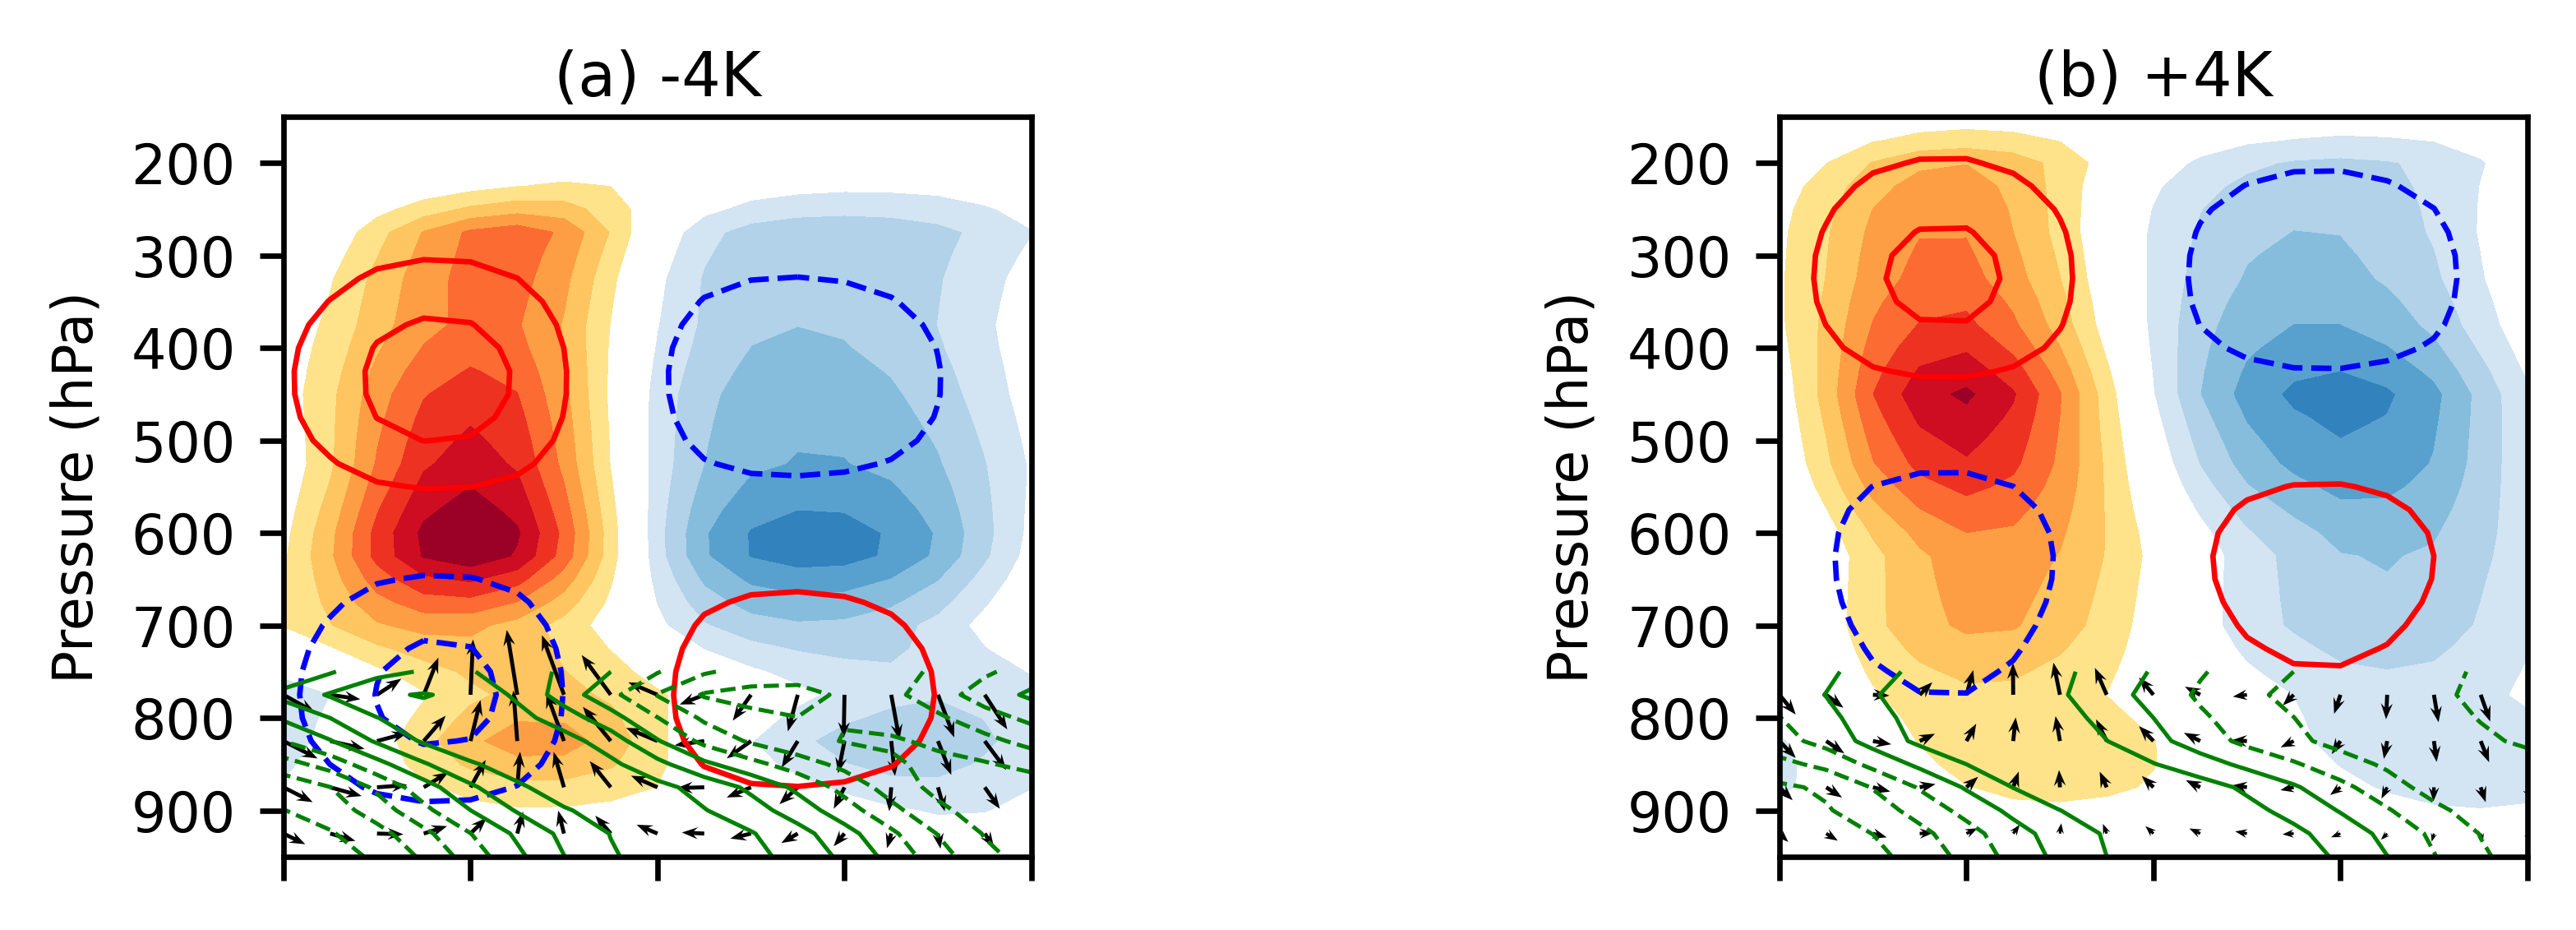

In [42]:
############################
# Fig.10: Plot schematic diagram (KW composite vertical structure of Q, T, q, uw)
##############################
title_noabc = list(['(a) -4K','CTL','(b) +4K'])
plot_cf_qTQ = 2 # or 0, if 0: plot q in contourf and T in contour; if 1: plot T in contourf and q in contour

clev_0 = 0
font = 8
i_list = np.array([0,2])

for plot_T_T1_T2 in range(2,3): # 0(T all) or 1(T1) or 2(T2) or 3(T1 and T2)
    
    fig,axes = plt.subplots(1,2,figsize=(6.5, 2),dpi=600)
    plt.subplots_adjust(left=0.2,right=0.9,top=0.9,bottom=0.15,wspace=1)
    plt.rcParams.update({'font.size': font})
    cn2_color = list(['g','k'])
    clev4_p = np.arange(0.8,2.4,0.8) #gph
    clev4_n = np.arange(-2.4,0,0.8) #gph
    var_cn4 = globals()['gph_only_lf_KW_all']
        
    for ii in range(0,2): #icase
        
        i = i_list[ii]
        plt.subplot(1,2,ii+1)
        ax = plt.gca()
        plt.title(title_noabc[i], pad=3, loc='center',fontsize=9)
        xx, yy = np.meshgrid(phase, plev)
        if plot_cf_qTQ==2:
            var_cn2 = globals()['q_only_lf_KW_all']
            if plot_T_T1_T2 == 2:
                var_cn = globals()['T2_KW_all']
                clev_n = np.arange(-0.21,0,0.03) # T
                clev_p = np.arange(0.03,0.24,0.03) # T
            var_cf = globals()['Q_KW_all']
            clev = np.arange(-0.8,0.9,0.1) # Q

            clev2_n = np.arange(-0.08,0,0.02)+0.01 # q
            clev2_p = np.arange(0.02,0.1,0.02)-0.01 # q
            # Plot Q
            cf  = plt.contourf(xx, yy, var_cf[:,:,i].T, levels=clev, cmap=get_cmap(RWB), extend='both' )
            # Plot T
            cn_p = plt.contour(xx, yy, var_cn[:,:,i].T, levels=clev_p, colors='r', linewidths=0.8)
            cn_n = plt.contour(xx, yy, var_cn[:,:,i].T, levels=clev_n, colors='b', linestyles='dashed',linewidths=0.8)
            #cn_0 = plt.contour(xx, yy, var_cn[:,:,i].T, levels=clev_0, colors='grey',linewidths=0.4)
            # Plot q
            cn2_p = plt.contour(xx, yy, var_cn2[:,:,i].T, levels=clev2_p, colors='g', linewidths=0.6)
            cn2_n = plt.contour(xx, yy, var_cn2[:,:,i].T, levels=clev2_n, colors='g', linestyles='dashed',linewidths=0.6)

        # Plot u and w (normalized by the physical legnth of x and y axis)
        skip = (slice(None, None, 2), slice(None, None, 1))
        skip2 = (slice(None, None, 1), slice(None, None, 2))
        u_norm_tmp = u_norm[:,:,i]
        w_norm_tmp = w_norm[:,:,i]
        plt.quiver(xx[skip], yy[skip], u_norm_tmp[skip2].T, -w_norm_tmp[skip2].T,units='inches',scale=1.5*10**(-6), \
                   width=0.008, headwidth=3, headlength=4, headaxislength=3)#, pivot='middle')
        
        plt.ylim([150,np.max(plev)])
        plt.yticks(np.arange(200,1000,100))
        plt.gca().invert_yaxis()
        plt.xticks(np.arange(-pi,pi+pi/2,pi/2),(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
        plt.tick_params(bottom=True,top=False,left=True,right=False)
        plt.tick_params(labelbottom=False,labeltop=False,labelleft=True,labelright=False)
        ax.yaxis.set_label_position("left")
        ax.set_ylabel('Pressure (hPa)',fontsize=font)
    if plot_T_T1_T2 == 2:
        plt.savefig(figdir+'Fig.10_Schematic_T2.png',dpi=600)  
    plt.show()

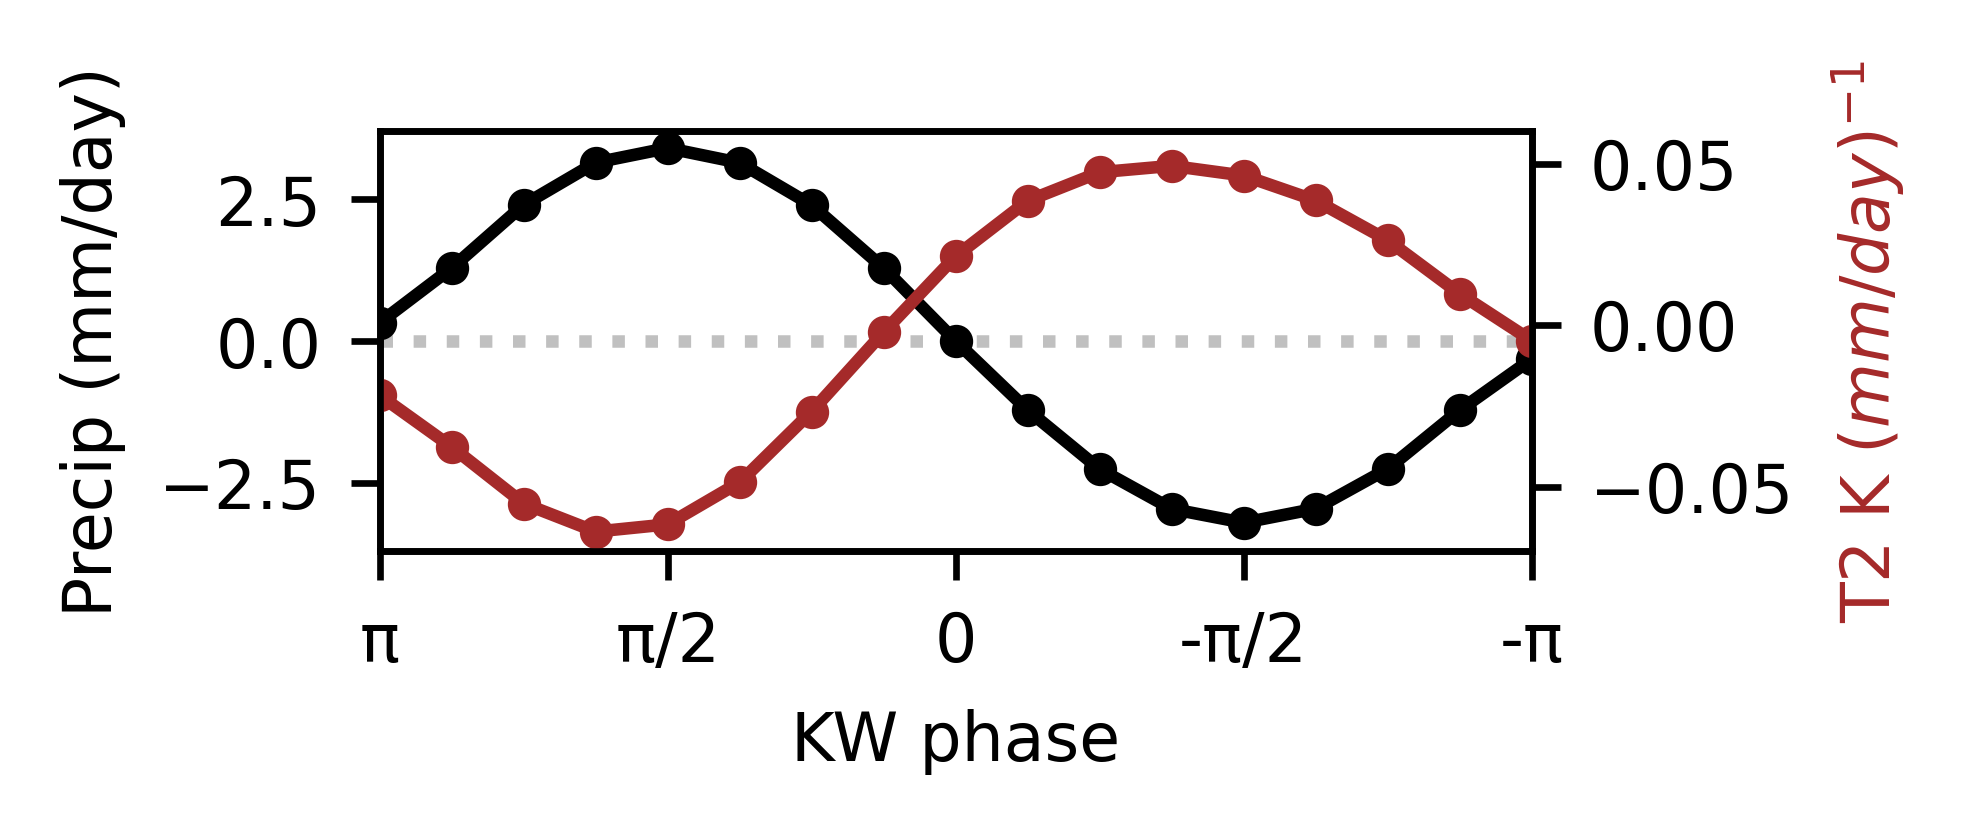

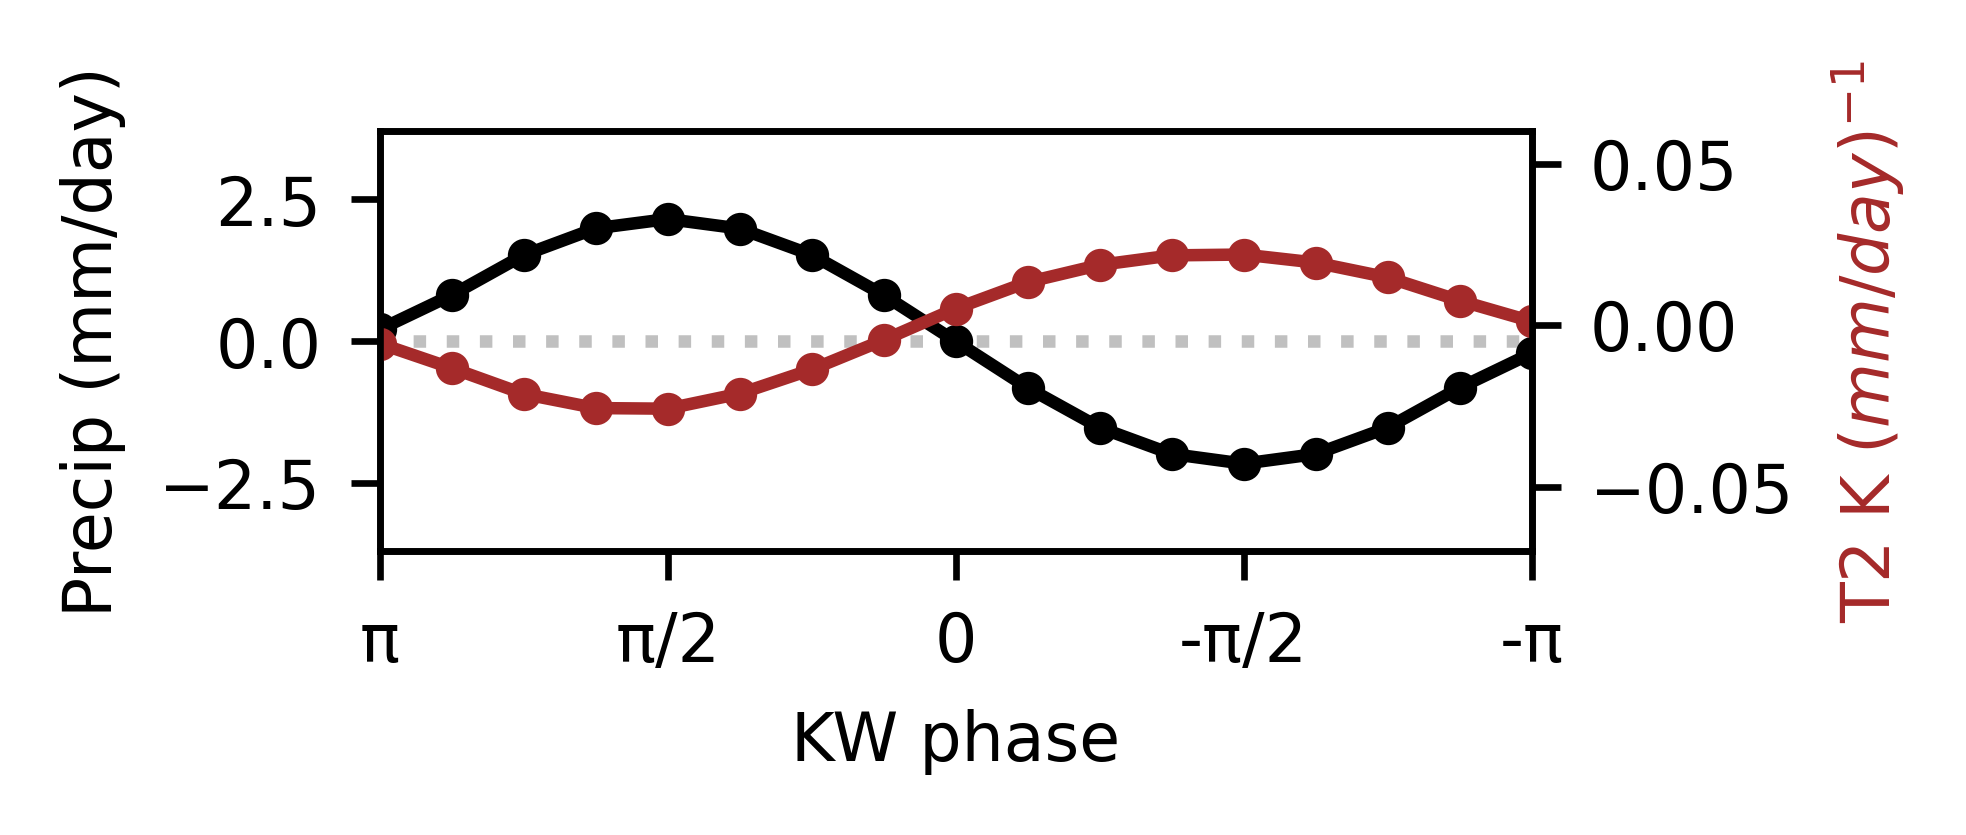

In [36]:
###############################################
# Fig.10: Plot schematic diagram (lower plot), precip and T2
######################################################
zero = np.zeros([nphase])
title = list(['-4K','CTL','+4K'])

for icase in range(0,4,2):
    fig,ax = plt.subplots(1,1,figsize=(3.2, 1.4),dpi=600)
    plt.subplots_adjust(left=0.2,right=0.8,top=0.8,bottom=0.3)
    plt.subplot(1,1,1)
    ax.plot(phase, zero, color='silver',linestyle='dotted')
    ax.plot(phase, pr_KW_all[:,icase],color='k',marker='o',markersize=3)
    ax.set_xlim([-pi,pi])
    ax.set_ylim([-3.7, 3.7])
    ax.set_ylabel('Precip (mm/day)')
    #
    ax2 = ax.twinx()
    ax2.plot(phase, T2_lf_KW_all[:,icase],color='brown',marker='o',markersize=3) #used to be brown
    ax2.set_ylim([-0.07, 0.06])
    ax2.set_ylabel('T2 K $({mm/day})^{-1}$',color='brown')
    ax.set_xticks(np.arange(-pi,pi+pi/2,pi/2),(PI,PI+'/2','0','-'+PI+'/2','-'+PI),fontsize=font)
    ax.set_xlabel('KW phase')
    plt.savefig(figdir+'Fig.10_pr_T2_'+title[icase]+'.png',dpi=600)
    plt.show()